# Imports and dataset merge

### Place the two arffs in the datasets folder. If you want to run this code, 
### I placed a requirements.txt in the working space. I used Python 3.11. 

In [42]:
import pandas as pd
import arff
import seaborn as sb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.cbook as cbook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
import warnings
#  disable warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data_freq = arff.load('datasets/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('datasets/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [4]:
sev_counts = df_sev['IDpol'].value_counts()
for idpol, count in sev_counts.items():
    if idpol not in df_freq["IDpol"]:
        continue
    else:
        claim_nb = df_freq.loc[df_freq["IDpol"] == idpol, "ClaimNb"].iloc[0]
        if count != claim_nb:
            print(f"IDPol {idpol} does not align with Claimnb")

In [5]:
# merge the two datasets on the IDPol
df_sev_agg = df_sev.groupby('IDpol').agg({'ClaimAmount': 'sum'}).reset_index()
df_claim = df_freq.merge(df_sev_agg, on='IDpol', how='inner')

In [6]:
# create the target variable
df_claim['Target'] = df_claim['ClaimAmount'] / df_claim['Exposure']

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_claim.describe()

IDpol   ClaimNb  Exposure  VehPower    VehAge   DrivAge  \
count   24944.000 24944.000 24944.000 24944.000 24944.000 24944.000   
mean  2262558.278     1.060     0.693     6.469     7.386    45.140   
std   1578475.240     0.290     0.314     2.013     5.174    14.658   
min       139.000     1.000     0.003     4.000     0.000    18.000   
25%   1082689.500     1.000     0.450     5.000     3.000    34.000   
50%   2130098.500     1.000     0.760     6.000     7.000    45.000   
75%   3178541.750     1.000     1.000     7.000    11.000    54.000   
max   6113971.000    16.000     2.000    15.000    99.000    99.000   

       BonusMalus   Density  ClaimAmount       Target  
count   24944.000 24944.000    24944.000    24944.000  
mean       64.930  1984.306     2401.749    10417.567  
std        19.865  4119.720    30264.754   191698.891  
min        50.000     2.000        1.000        1.000  
25%        50.000   111.000      749.788     1128.000  
50%        55.000   495.000     1172.000     1504.160  
75%        76.000  2120.000     1346.400     3352.010  
max       228.000 27000.000  4075400.560 18524548.000

In [8]:
df_claim

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
0         139.000    1.000     0.750  'F'     7.000   1.000   61.000   
1         190.000    1.000     0.140  'B'    12.000   5.000   50.000   
2         414.000    1.000     0.140  'E'     4.000   0.000   36.000   
3         424.000    2.000     0.620  'F'    10.000   0.000   51.000   
4         463.000    1.000     0.310  'A'     5.000   0.000   45.000   
...           ...      ...       ...  ...       ...     ...      ...   
24939 6113521.000    1.000     0.180  'C'     4.000   1.000   26.000   
24940 6113793.000    1.000     0.140  'C'     7.000   2.000   51.000   
24941 6113817.000    1.000     0.170  'D'     4.000   0.000   35.000   
24942 6113834.000    2.000     0.170  'C'    15.000   3.000   36.000   
24943 6113971.000    1.000     0.130  'D'     7.000  10.000   39.000   

       BonusMalus VehBrand   VehGas   Density Region  ClaimAmount    Target  
0          50.000    'B12'  Regular 27000.000  'R11'      303.000   404.000  
1          60.000    'B12'   Diesel    56.000  'R25'     1981.840 14156.000  
2          85.000    'B12'  Regular  4792.000  'R11'     1456.550 10403.929  
3         100.000    'B12'  Regular 27000.000  'R11'    10834.000 17474.194  
4          50.000    'B12'  Regular    12.000  'R73'     3986.670 12860.226  
...           ...      ...      ...       ...    ...          ...       ...  
24939      60.000    'B12'   Diesel   311.000  'R82'     1324.400  7357.778  
24940      50.000    'B12'   Diesel   178.000  'R72'     1769.880 12642.000  
24941      51.000    'B12'  Regular  1719.000  'R82'     1288.280  7578.118  
24942      50.000    'B12'  Regular   181.000  'R54'    12230.400 71943.529  
24943      50.000     'B4'  Regular   820.000  'R41'     1452.000 11169.231  

[24944 rows x 14 columns]

# Visualise and understand data

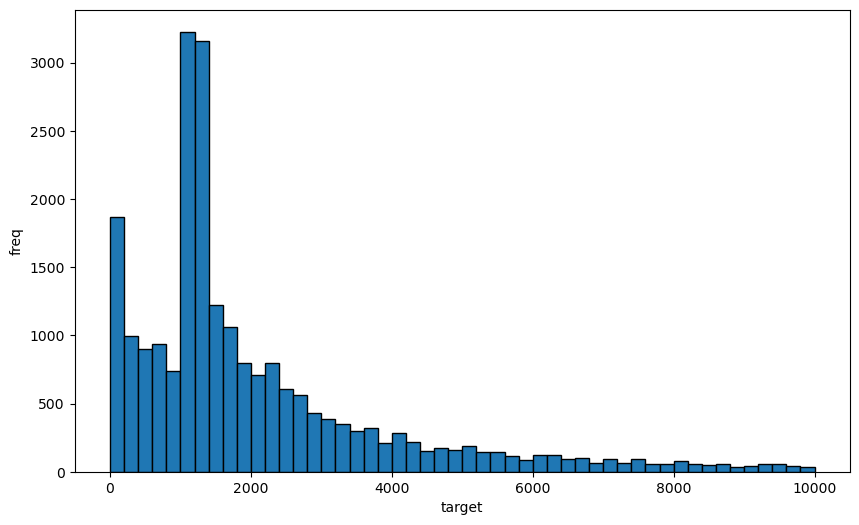

Std 191698.89121509562
Mean 10417.56660222827
Median 1504.1599999999999


In [9]:
filtered_data = df_claim['Target'][df_claim['Target'] <= 10000]
plt.figure(figsize=(10,6))
plt.hist(filtered_data, bins=50, edgecolor='black')
plt.xlabel('target')
plt.ylabel('freq')
plt.show()
print("Std", df_claim['Target'].std())
print("Mean", df_claim['Target'].mean())
print("Median", df_claim['Target'].median())

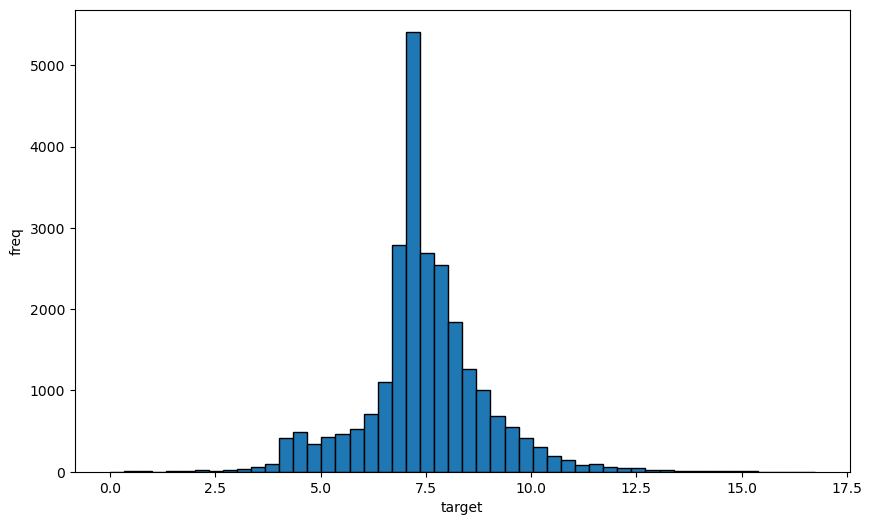

Std 191698.89121509562
Mean 10417.56660222827
Median 1504.1599999999999


In [10]:
filtered_data = np.log(df_claim['Target'])
plt.figure(figsize=(10,6))
plt.hist(filtered_data, bins=50, edgecolor='black')
plt.xlabel('target')
plt.ylabel('freq')
plt.show()
print("Std", df_claim['Target'].std())
print("Mean", df_claim['Target'].mean())
print("Median", df_claim['Target'].median())

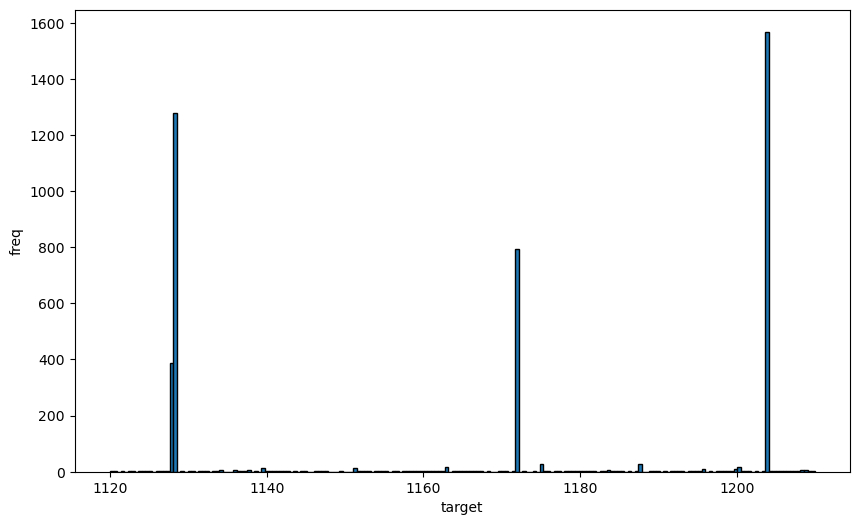

In [28]:
filtered_data = df_claim['Target'][(df_claim['Target'] >= 1120) & (df_claim['Target'] <= 1210)]
plt.figure(figsize=(10,6))
plt.hist(filtered_data, bins=200, edgecolor='black')
plt.xlabel('target')
plt.ylabel('freq')
plt.show()

In [29]:
print(df_claim["Target"].astype(int).value_counts())
df_claim_3_vals = df_claim[((df_claim['Target'] >= 1127) & (df_claim['Target'] <= 1129)) | 
                           ((df_claim['Target'] >= 1203) & (df_claim['Target'] <= 1205)) | 
                           ((df_claim['Target'] >= 1171) & (df_claim['Target'] <= 1173))]
df_without_specified_targets = df_claim[
    ~((df_claim['Target'] >= 1127) & (df_claim['Target'] <= 1129)) &
    ~((df_claim['Target'] >= 1203) & (df_claim['Target'] <= 1205)) &
    ~((df_claim['Target'] >= 1171) & (df_claim['Target'] <= 1173))
]
print(len(df_claim_3_vals)/len(df_without_specified_targets))

Target
1128     1666
1204     1573
1172      794
602       127
2256      115
         ... 
2159        1
2887        1
20881       1
4920        1
11169       1
Name: count, Length: 6617, dtype: int64
0.19616018617279163


### Around 20% of the data consist of sev. claims with same exposure, same claimNb & same claimAmount.
### This looks really off, but we keep it in.

In [14]:
# The outlier really skew the statistical analysis. Lets see how many claims are above 100,000
print(len(df_claim[df_claim['Target'] > 100000]) / len(df_claim))
# Well, it's only 1% of the claims, so we will remove them (first)
df_claim = df_claim[df_claim['Target'] <= 100000]

0.0


In [16]:
# Just some plotting functions
def plot_mean_var_plot_cat(column_name, dataframe=df_claim, target_column='Target', disable_occurance_label=True, drop_limit=None):
    # Grouping and calculating mean, variance, and count
    grouped = dataframe.groupby(column_name)[target_column].agg(['mean', 'var', 'count'])
    grouped = grouped.reset_index()

    # Apply drop_limit if specified
    if drop_limit is not None:
        grouped = grouped[grouped['count'] > drop_limit]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(grouped['mean'], grouped['var'], color='blue', label='Groups')
    
    # Annotating with category and count, based on disable_occurance_label
    for index, row in grouped.iterrows():
        label = f"{row[column_name]}"
        if not disable_occurance_label:
            label += f" (n={row['count']})"
        plt.annotate(label, (row['mean'], row['var']), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Labeling
    plt.xlabel(f'Mean of {target_column}')
    plt.ylabel(f'Variance of {target_column}')
    plt.title(f'Mean-Variance Plot by {column_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_mean_var_plot_cat_cat(column_name1, column_name2, dataframe=df_claim, target_column='Target', disable_occurance_label = False):
    # Grouping and calculating mean, variance, and count
    grouped = dataframe.groupby([column_name1, column_name2])[target_column].agg(['mean', 'var', 'count'])
    grouped = grouped.reset_index()

    # Creating a Faceted Grid Plot
    g = sb.FacetGrid(grouped, col=column_name2, col_wrap=4, height=4, sharex=False, sharey=False)
    g.map(plt.scatter, 'mean', 'var', color='blue')

    # Iterating through each axis (subplot) to annotate points with category and count
    for ax, (_, sub_data) in zip(g.axes.flat, grouped.groupby(column_name2)):
        for _, row in sub_data.iterrows():
            label = f"{row[column_name1]}"
            if disable_occurance_label:
                label += f"(n={row['count']})"
            ax.annotate(label, (row['mean'], row['var']), textcoords="offset points", xytext=(0,10), ha='center')

    # Labeling
    g.set_axis_labels('Mean', 'Variance')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Mean-Variance Plot by {column_name1} and {column_name2}')
    g.add_legend()
    plt.show()


def plot_metric_data(column_name, dataframe = df_claim, bins=100):
    filtered_data = dataframe[column_name]
    plt.figure(figsize=(10,6))
    plt.hist(filtered_data, bins=bins, edgecolor='black')
    plt.xlabel('target')
    plt.ylabel('freq')
    plt.show()

def plot_metric_data_arr(data, bins=100):

    print(len(data))
    # Ensure the input data is a numpy array
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    # Filtering the data to include only values less than 10000
    filtered_data = data[data < 10000]

    # Setting up the plot
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_data, bins=bins, edgecolor='black')

    # Setting labels and showing the plot
    plt.xlabel('target')
    plt.ylabel('freq')
    plt.show()

def plot_contour_heatmap(col1, col2, max_x = None, max_y = None):
    # Plotting the contour plot / heatmap
    plt.figure(figsize=(10, 6))
    sb.kdeplot(x=df_claim[col1], y=df_claim[col2], cmap="Reds", fill=True, bw_adjust=0.5)
    
    if max_x:
        plt.xlim(0, max_x)
    if max_y:
        plt.ylim(0, max_y)
    
    plt.title('Contour Plot')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

def plot_qq(y_pred, y_actual):
    plt.figure(figsize=(6, 6))
    stats.probplot(y_pred - y_actual, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.show()

def plot_gt_and_preds(gts, preds, limit=10000):
    plt.figure(figsize=(12, 6))
    
    # Plotting the distribution of actual values
    plt.subplot(1, 2, 1)
    plt.hist(gts[gts < limit], bins=100, alpha=0.7, color='blue')
    plt.title('Distribution of Actual Values')
    plt.xlabel('Actual Value')
    plt.ylabel('Frequency')
    plt.ylim(0, 2000)
    
    # Plotting the distribution of predicted values
    plt.subplot(1, 2, 2)
    plt.hist(preds[preds < limit], bins=100, alpha=0.7, color='green')
    plt.title('Distribution of Predicted Values')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.ylim(0, 2000)
    
    plt.tight_layout()
    plt.show()
    


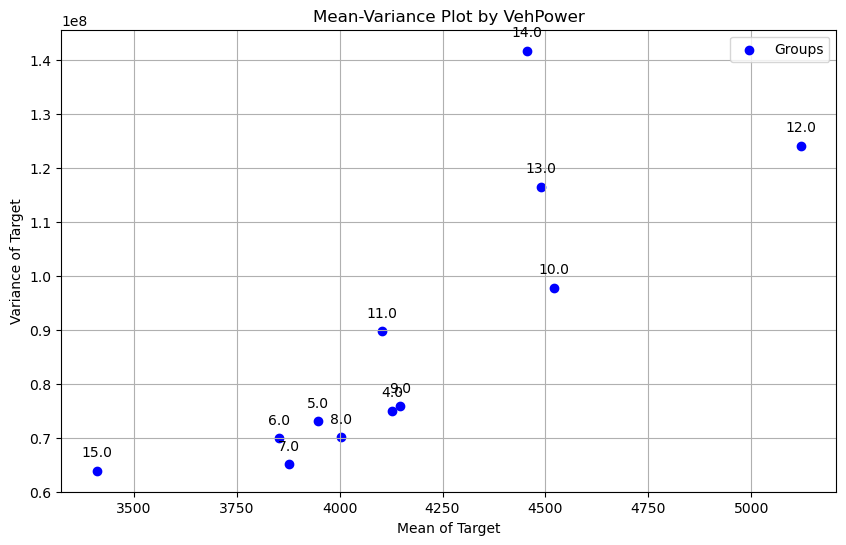

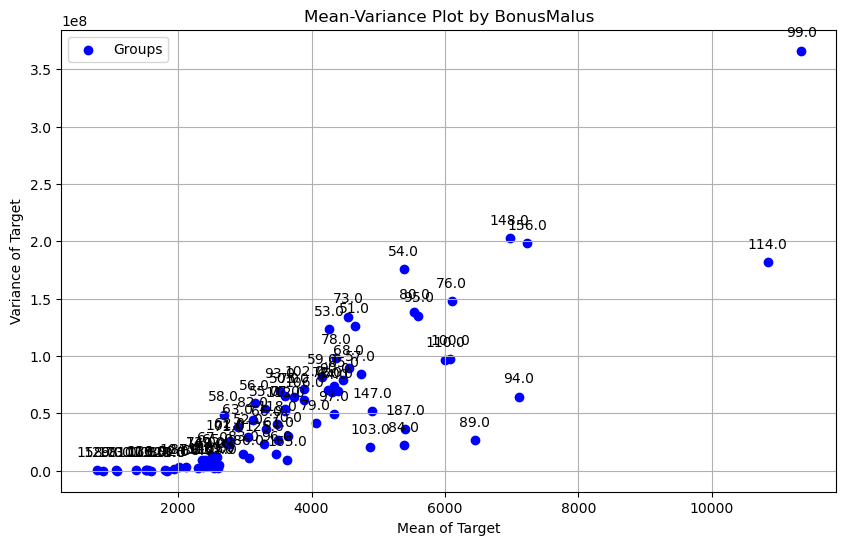

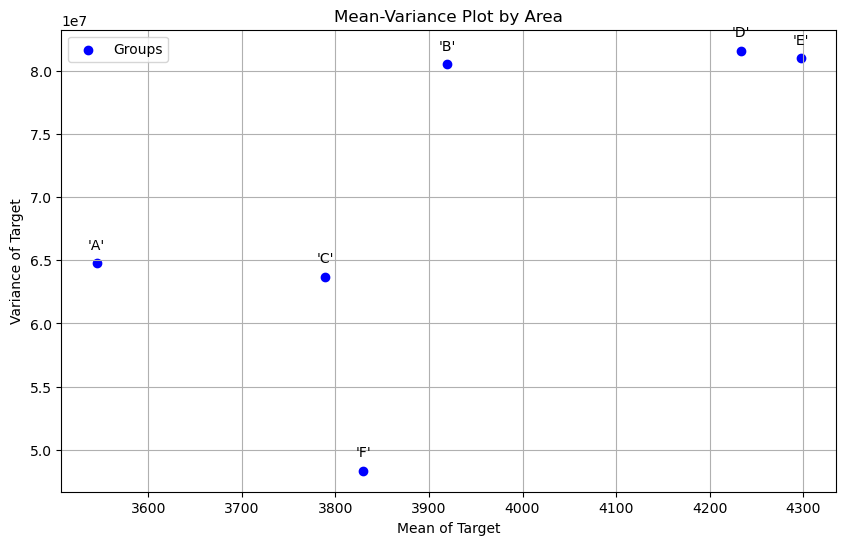

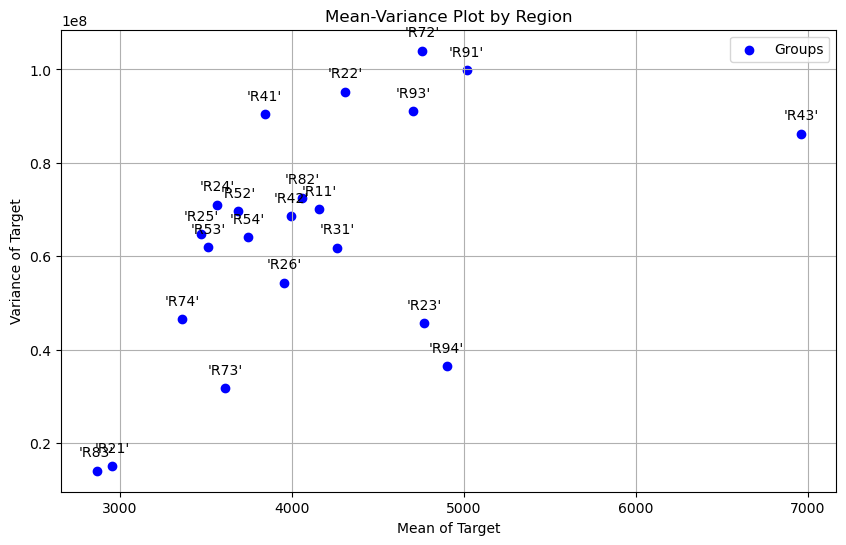

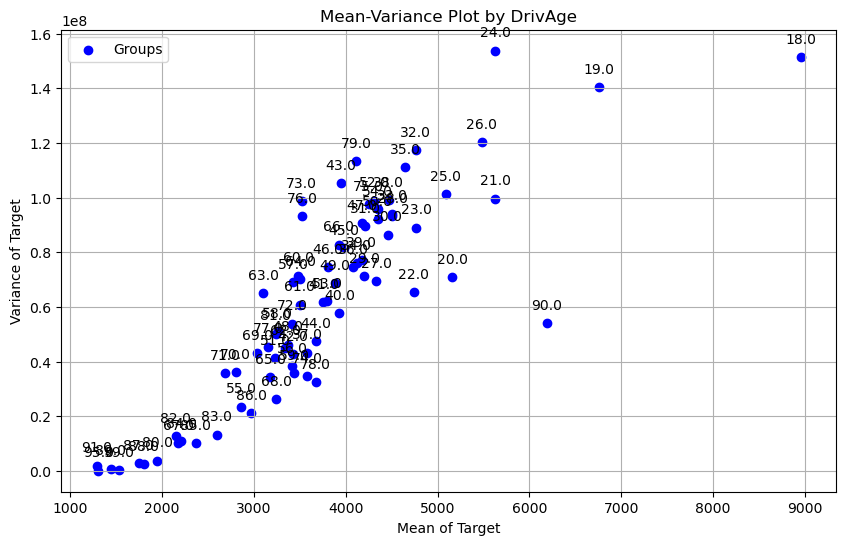

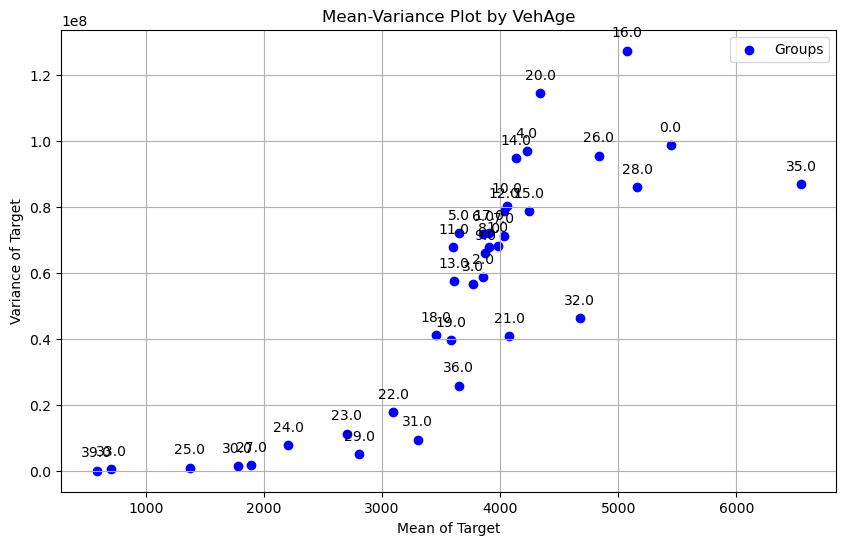

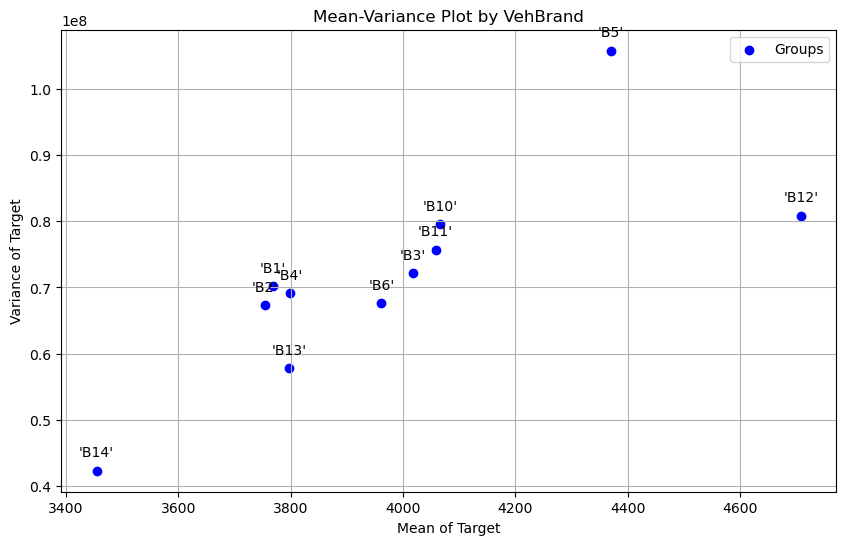

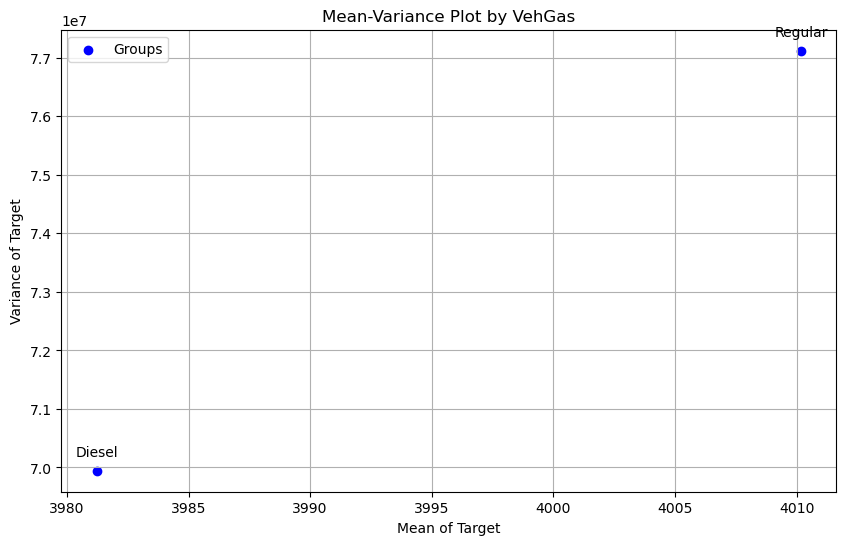

In [18]:
plot_mean_var_plot_cat('VehPower')
plot_mean_var_plot_cat('BonusMalus')
plot_mean_var_plot_cat('Area')
plot_mean_var_plot_cat('Region')
plot_mean_var_plot_cat('DrivAge')
plot_mean_var_plot_cat('VehAge')
plot_mean_var_plot_cat('VehBrand')
plot_mean_var_plot_cat('VehGas')

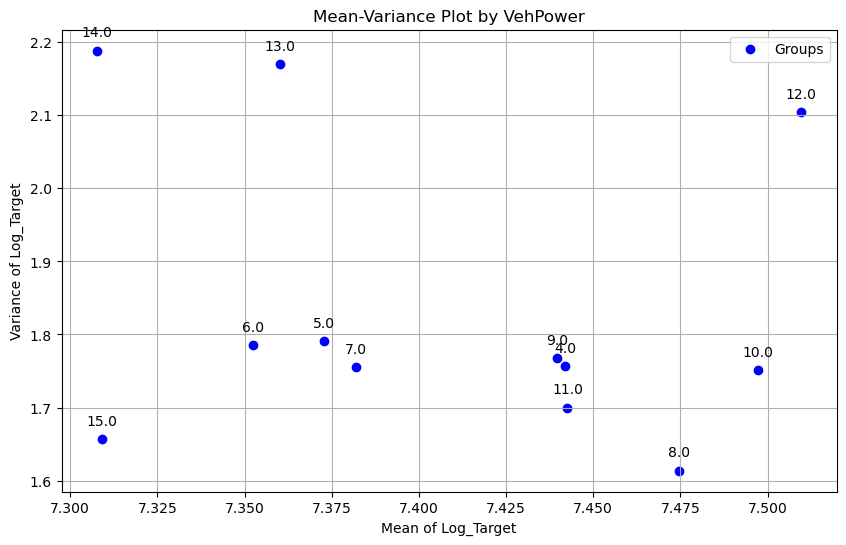

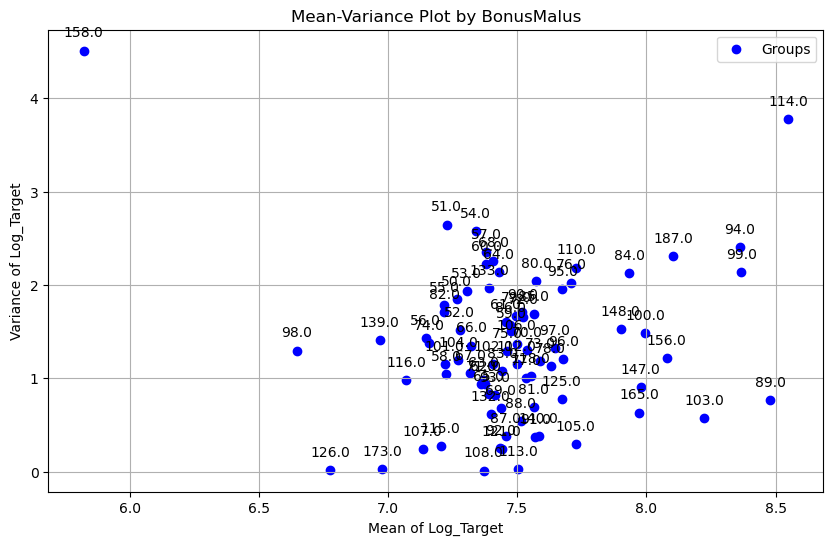

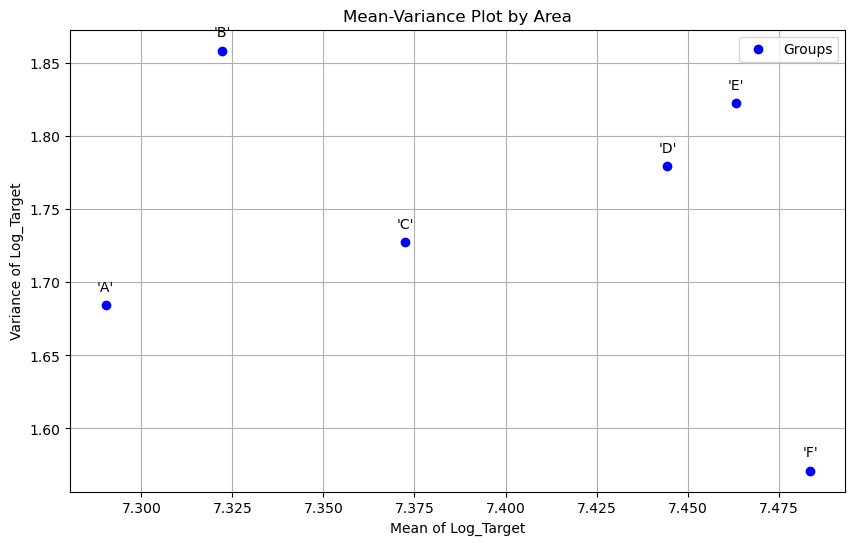

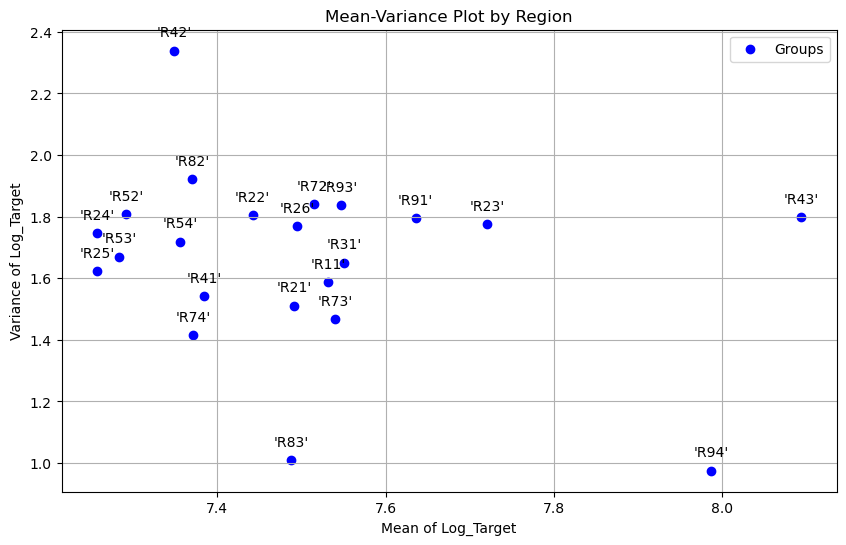

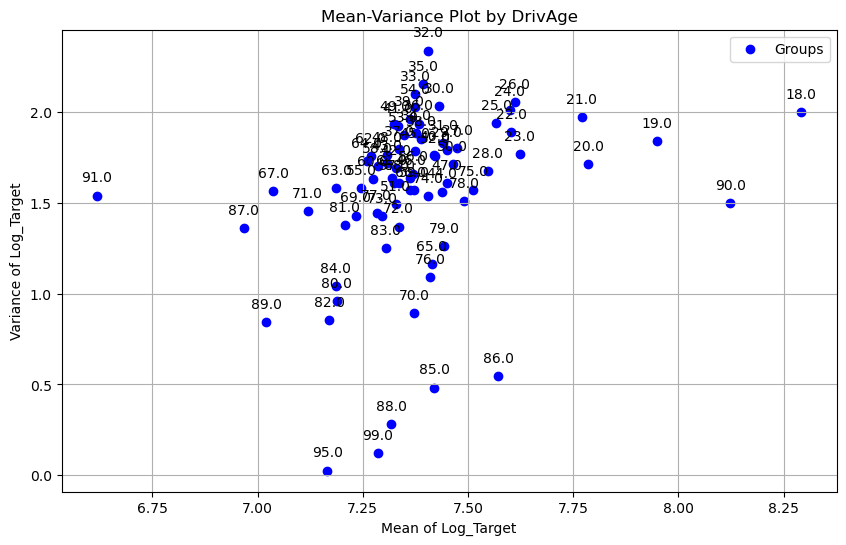

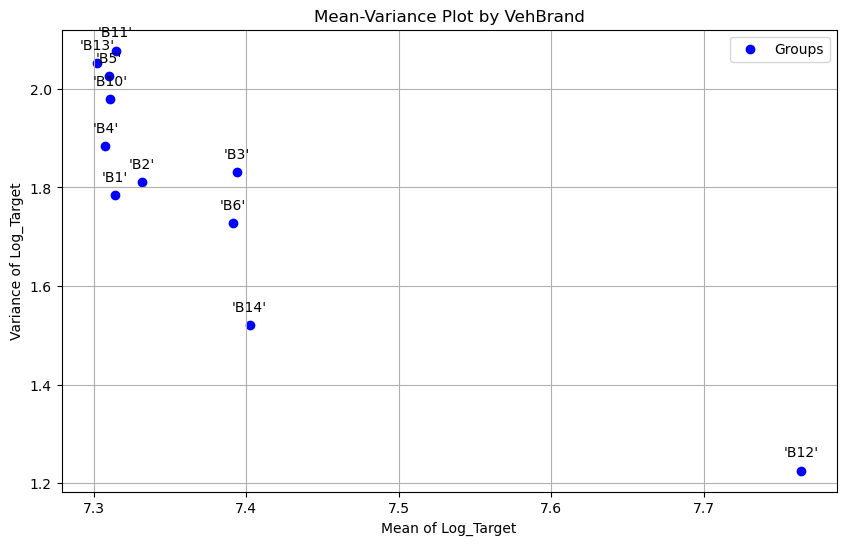

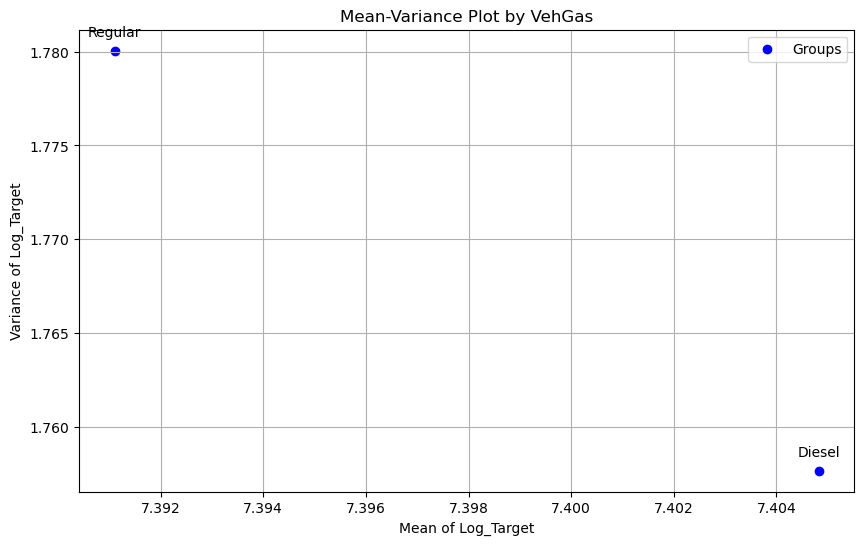

In [19]:
df_claim['Log_Target'] = np.log(df_claim['Target'])
plot_mean_var_plot_cat('VehPower', target_column="Log_Target")
plot_mean_var_plot_cat('BonusMalus', target_column="Log_Target")
plot_mean_var_plot_cat('Area', target_column="Log_Target")
plot_mean_var_plot_cat('Region', target_column="Log_Target")
plot_mean_var_plot_cat('DrivAge', target_column="Log_Target")
plot_mean_var_plot_cat('VehBrand', target_column="Log_Target")
plot_mean_var_plot_cat('VehGas', target_column="Log_Target")

### Even though log transformation might look applicable, it also destroys obvious patterns (in the plots).
### I decided not to use it (I tried it once, but performance was a tiny bit worse). 

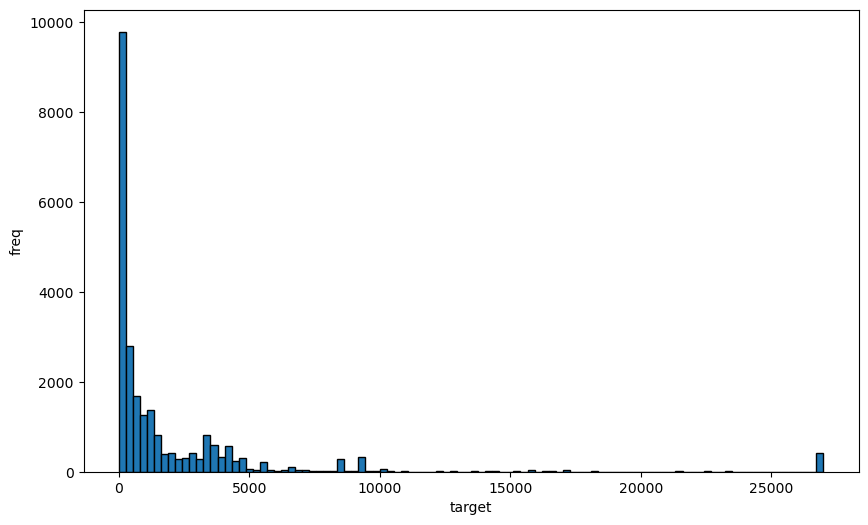

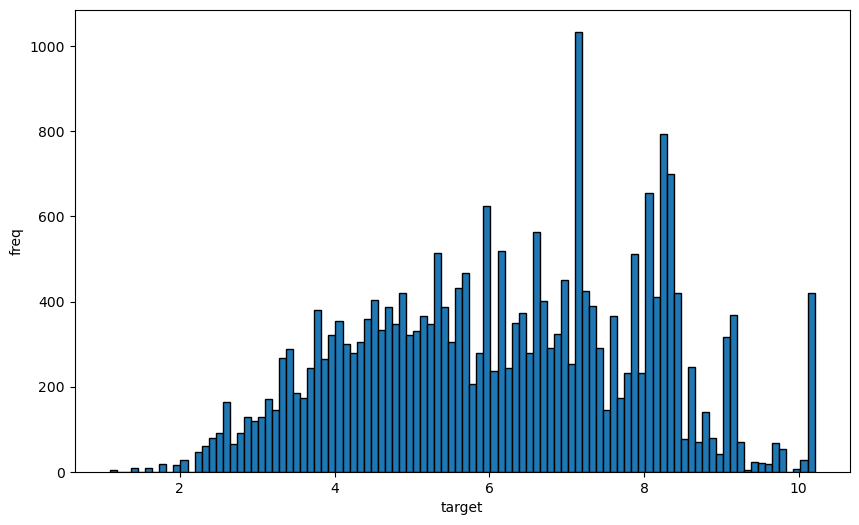

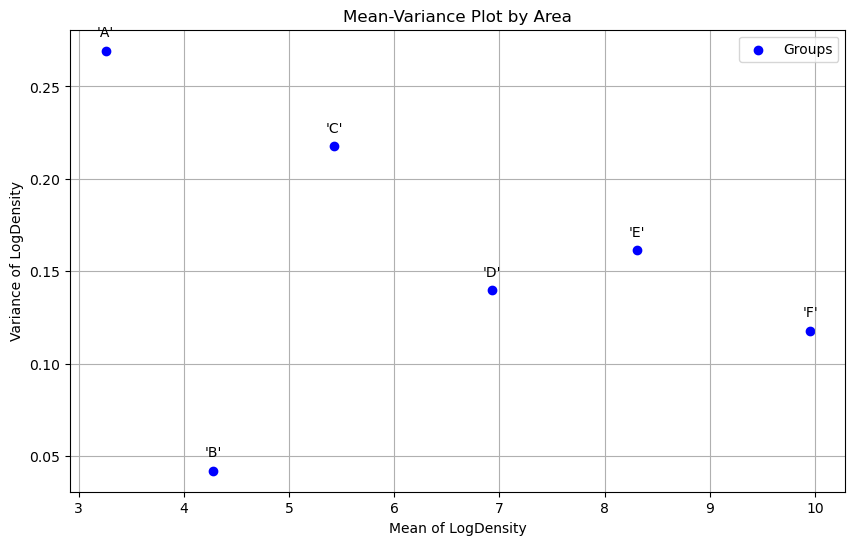

In [20]:
plot_metric_data('Density')
df_claim['LogDensity'] = np.log(df_claim['Density'] + 1)
plot_metric_data('LogDensity')
plot_mean_var_plot_cat('Area', target_column="LogDensity")

### We can use logtransformation on the density though...

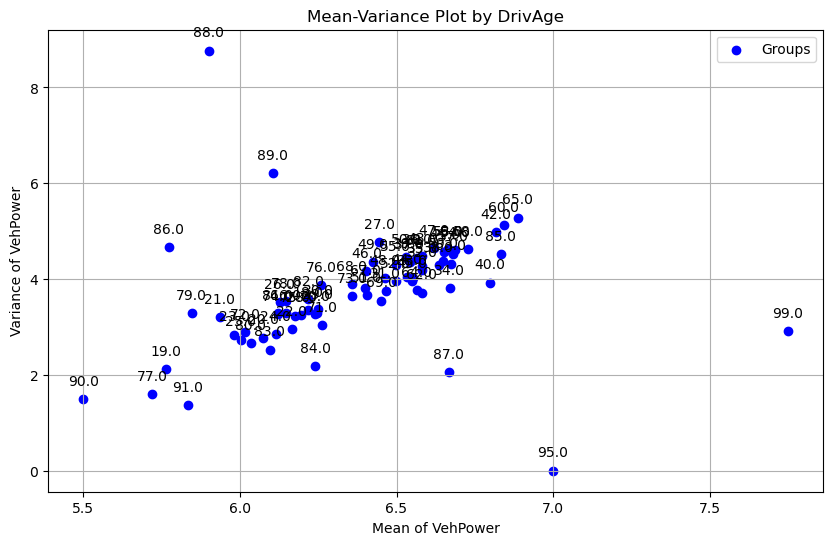

In [21]:
plot_mean_var_plot_cat('DrivAge', target_column="VehPower")

### - The data is quite noisy, so we will discretize it. The critical ages, like 18, 19, etc., up to about 25, will be looked at in more detail.
### - Based on the previous plot, we will label the following age groups (DrivAge): 18-19, 20-21, 22-25, 26-30, 31-40, 41-50, 51-60, 61-70, 71-99.

In [22]:
bins = [df_claim['DrivAge'].min(), 19, 21, 25, 30, 40, 50, 60, 70, df_claim['DrivAge'].max()]
labels = ['18-19', '20-21', '22-25', '26-30', '31-40', '41-50', '51-60', '61-70', '71-99']

df_claim['DrivAgeClass'] = pd.cut(df_claim['DrivAge'], bins=bins, labels=labels, right=True, include_lowest=True)

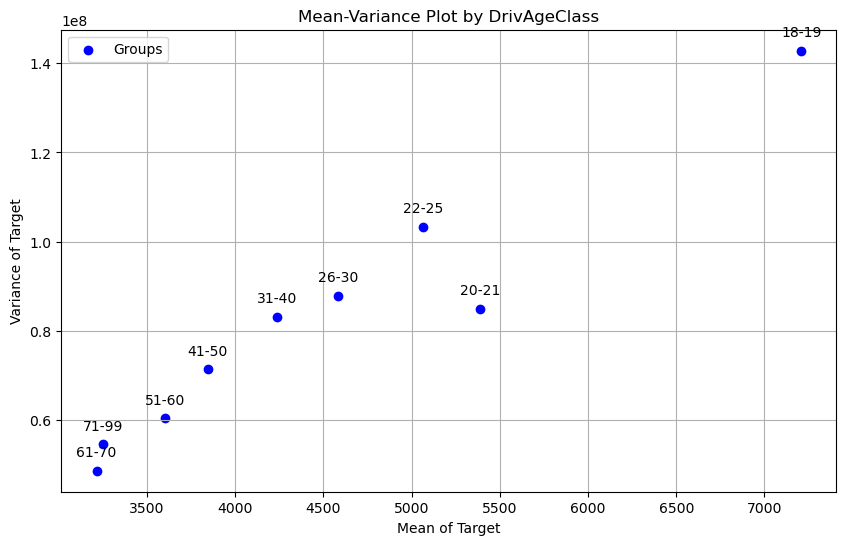

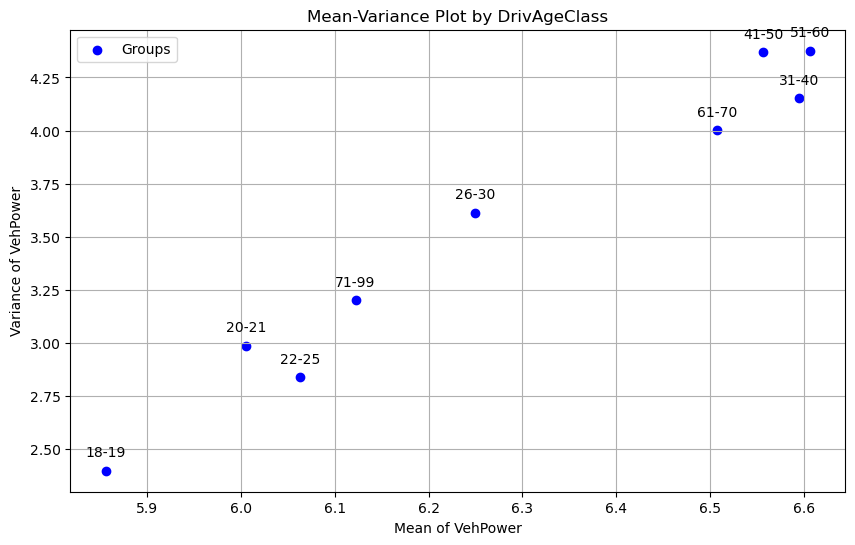

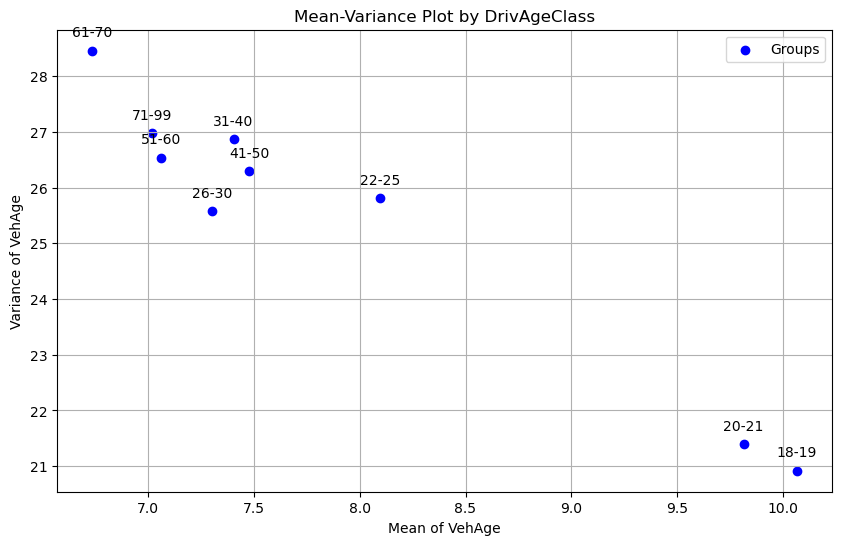

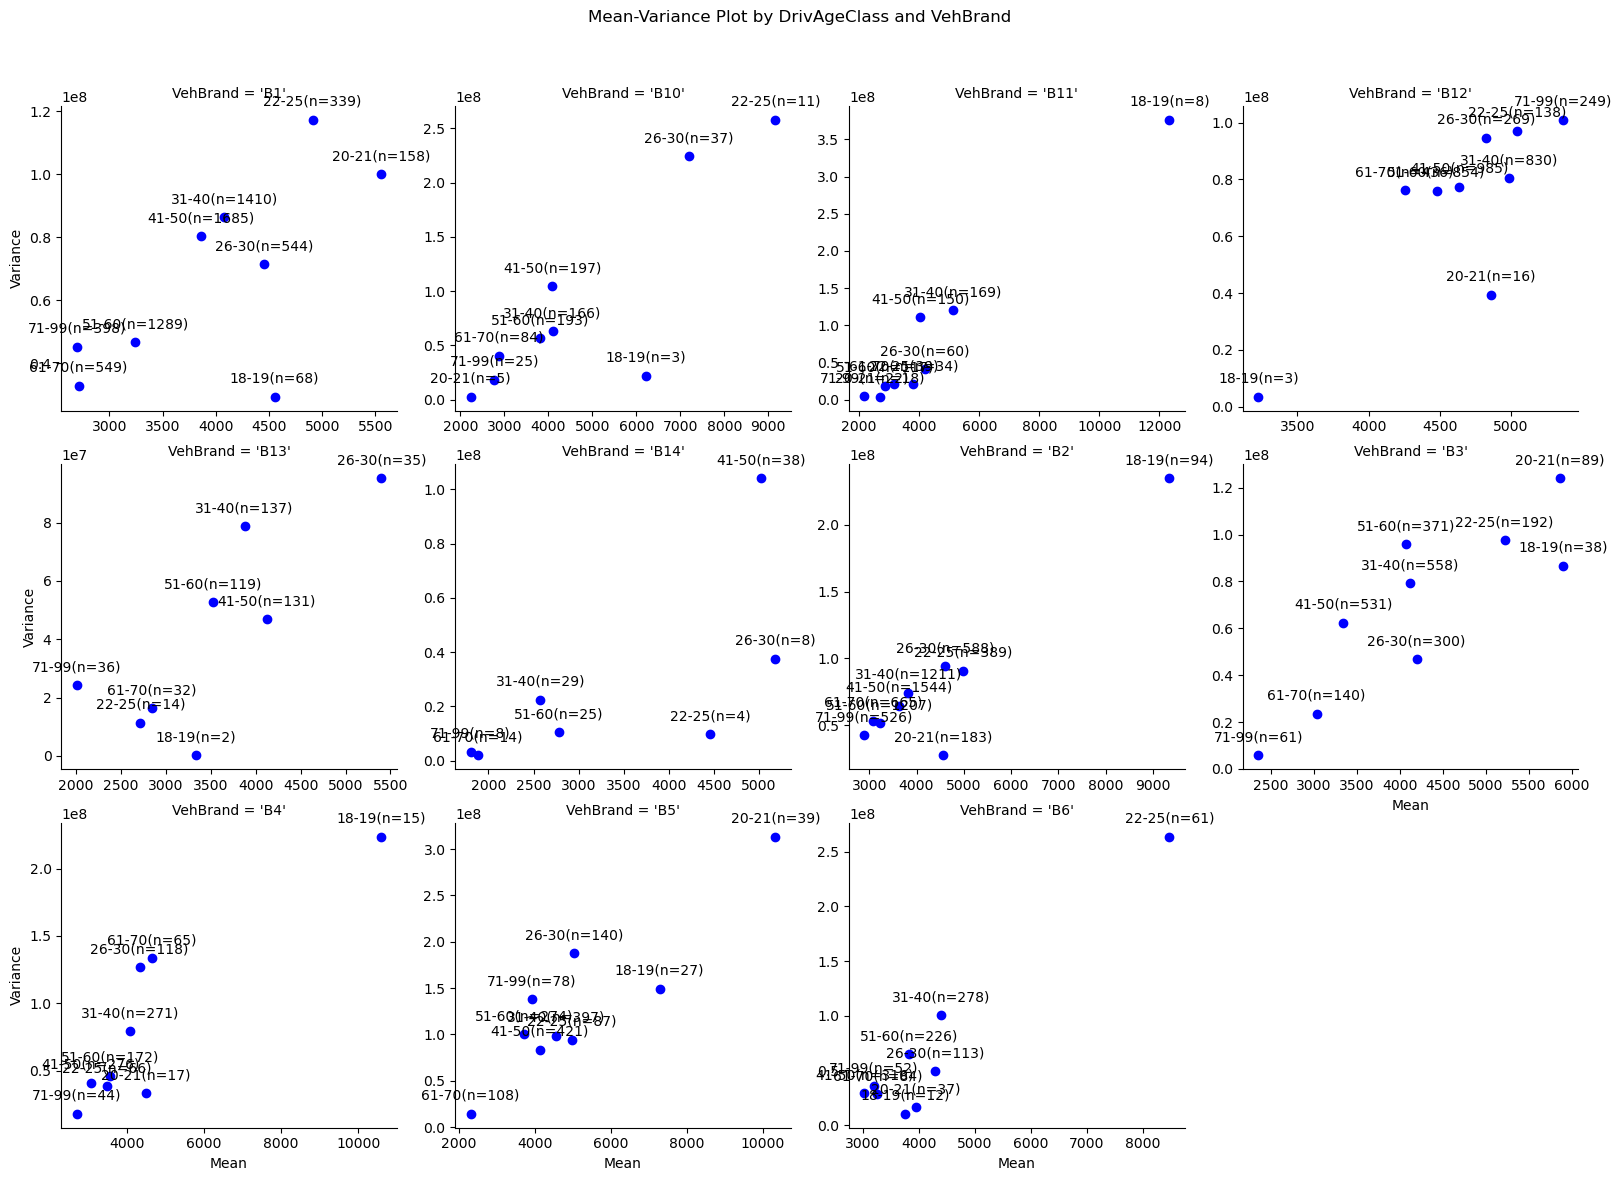

In [23]:
plot_mean_var_plot_cat('DrivAgeClass', target_column="Target")
plot_mean_var_plot_cat('DrivAgeClass', target_column="VehPower", disable_occurance_label=True)
plot_mean_var_plot_cat('DrivAgeClass', target_column="VehAge")
plot_mean_var_plot_cat_cat('DrivAgeClass', "VehBrand", disable_occurance_label=True)

### Looks better and cleaner... 

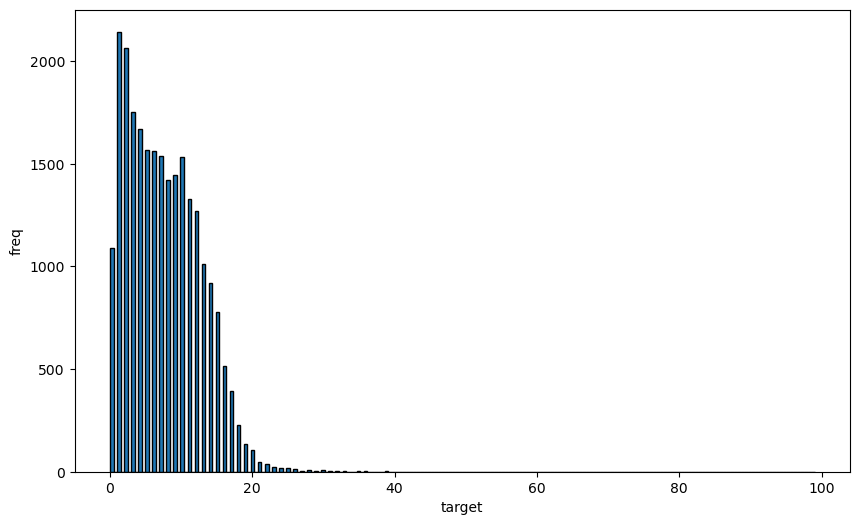

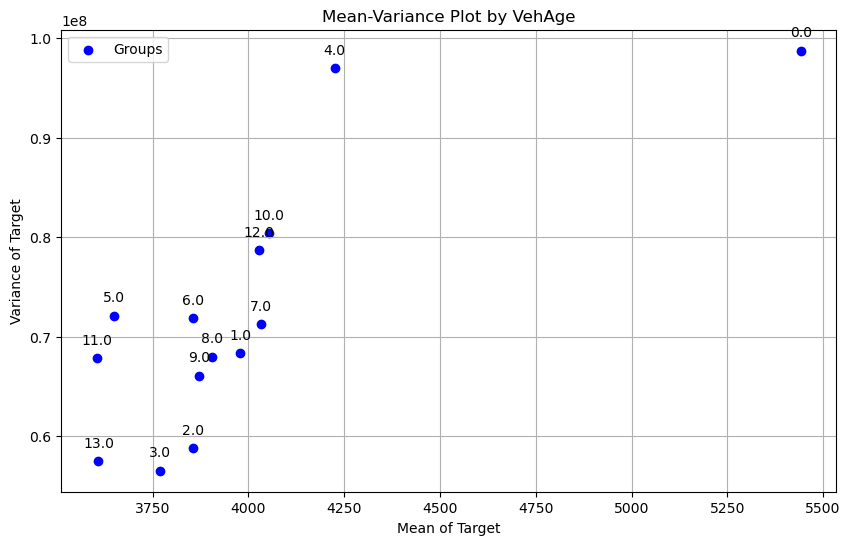

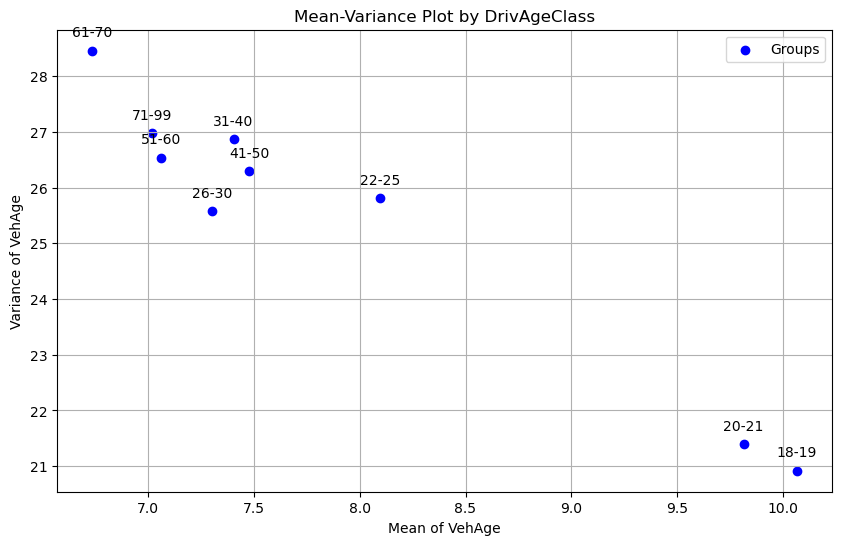

In [24]:
plot_metric_data('VehAge', bins=200)
plot_mean_var_plot_cat('VehAge', target_column = 'Target', disable_occurance_label=True, drop_limit=1000)
plot_mean_var_plot_cat('DrivAgeClass', target_column = 'VehAge', disable_occurance_label=True)

### Die 0 betrachten wir aufgrund der Outlierstellung separat. 1-2, 3-4, 5-10, 11-X

In [25]:
bins = [0, 1, 2, 4, 10, df_claim['VehAge'].max()]
labels = ['0', '1-2', '3-4', '5-10', '11+']
df_claim['VehAgeClass'] = pd.cut(df_claim['VehAge'], bins=bins, labels=labels, right=False, include_lowest=True)

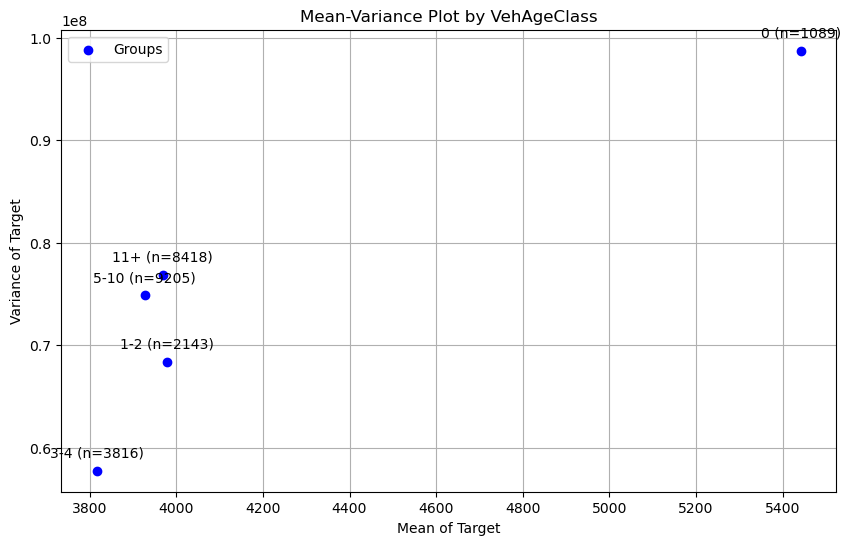

In [26]:
plot_mean_var_plot_cat('VehAgeClass', target_column = 'Target', disable_occurance_label=False)

### vehiclePower is ordinal and can therefore be discretized even better. Here I have merged the underrepresented classes.
### With a count of 92 and 91 in class 15 and 14 respectively, we can consider the result as not statistically significant. Thus, the underrepresented classes 12, 13, 14, and 15 are merged.

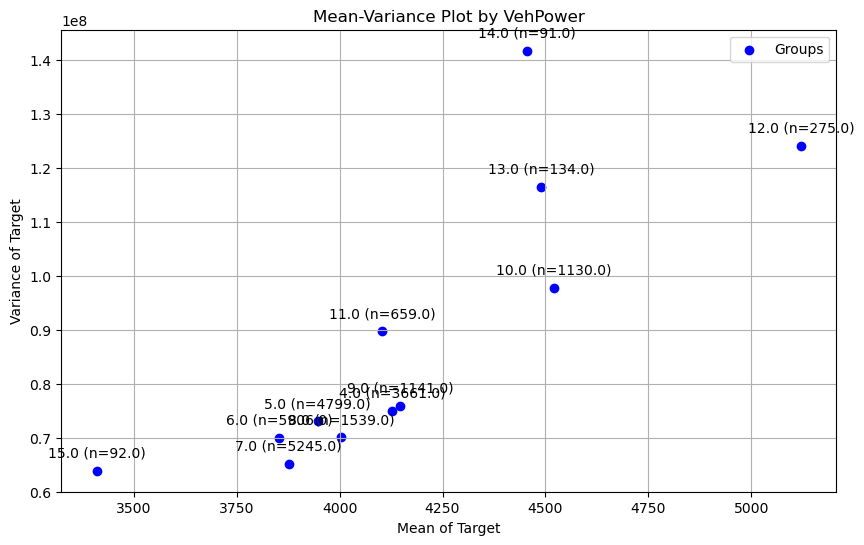

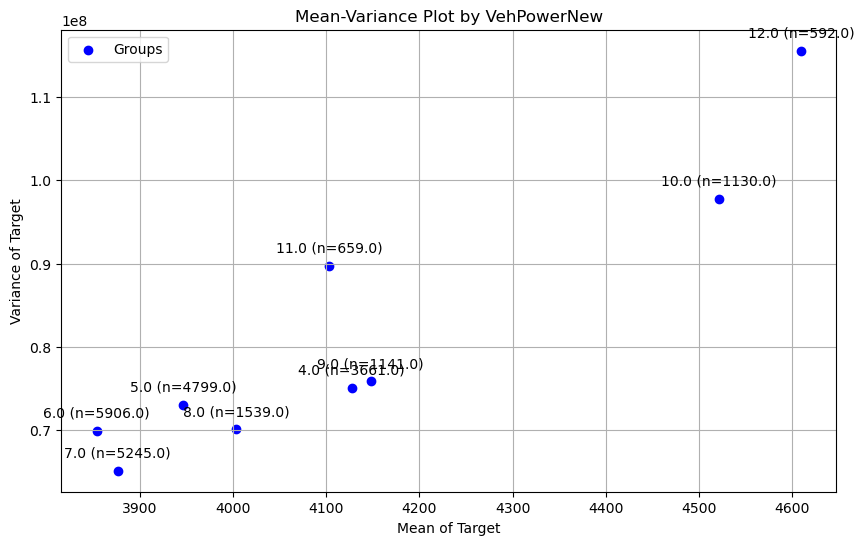

In [31]:
plot_mean_var_plot_cat('VehPower', disable_occurance_label=False)
df_claim['VehPowerNew'] = df_claim['VehPower']
condition = df_claim['VehPowerNew'].isin([13, 14, 15])
df_claim.loc[condition, 'VehPowerNew'] = 12.0
plot_mean_var_plot_cat('VehPowerNew', disable_occurance_label=False)


### We also have too many regions that are underrepresented. The problem is that regions are neither metric nor ordinal. Additional geographical information would be needed.

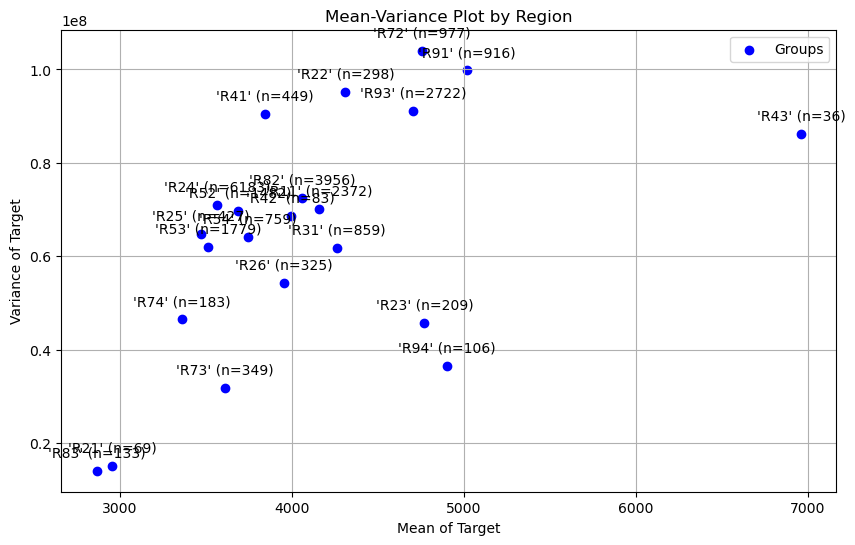

In [32]:
plot_mean_var_plot_cat('Region', disable_occurance_label=False)

### Found something on the internet though...

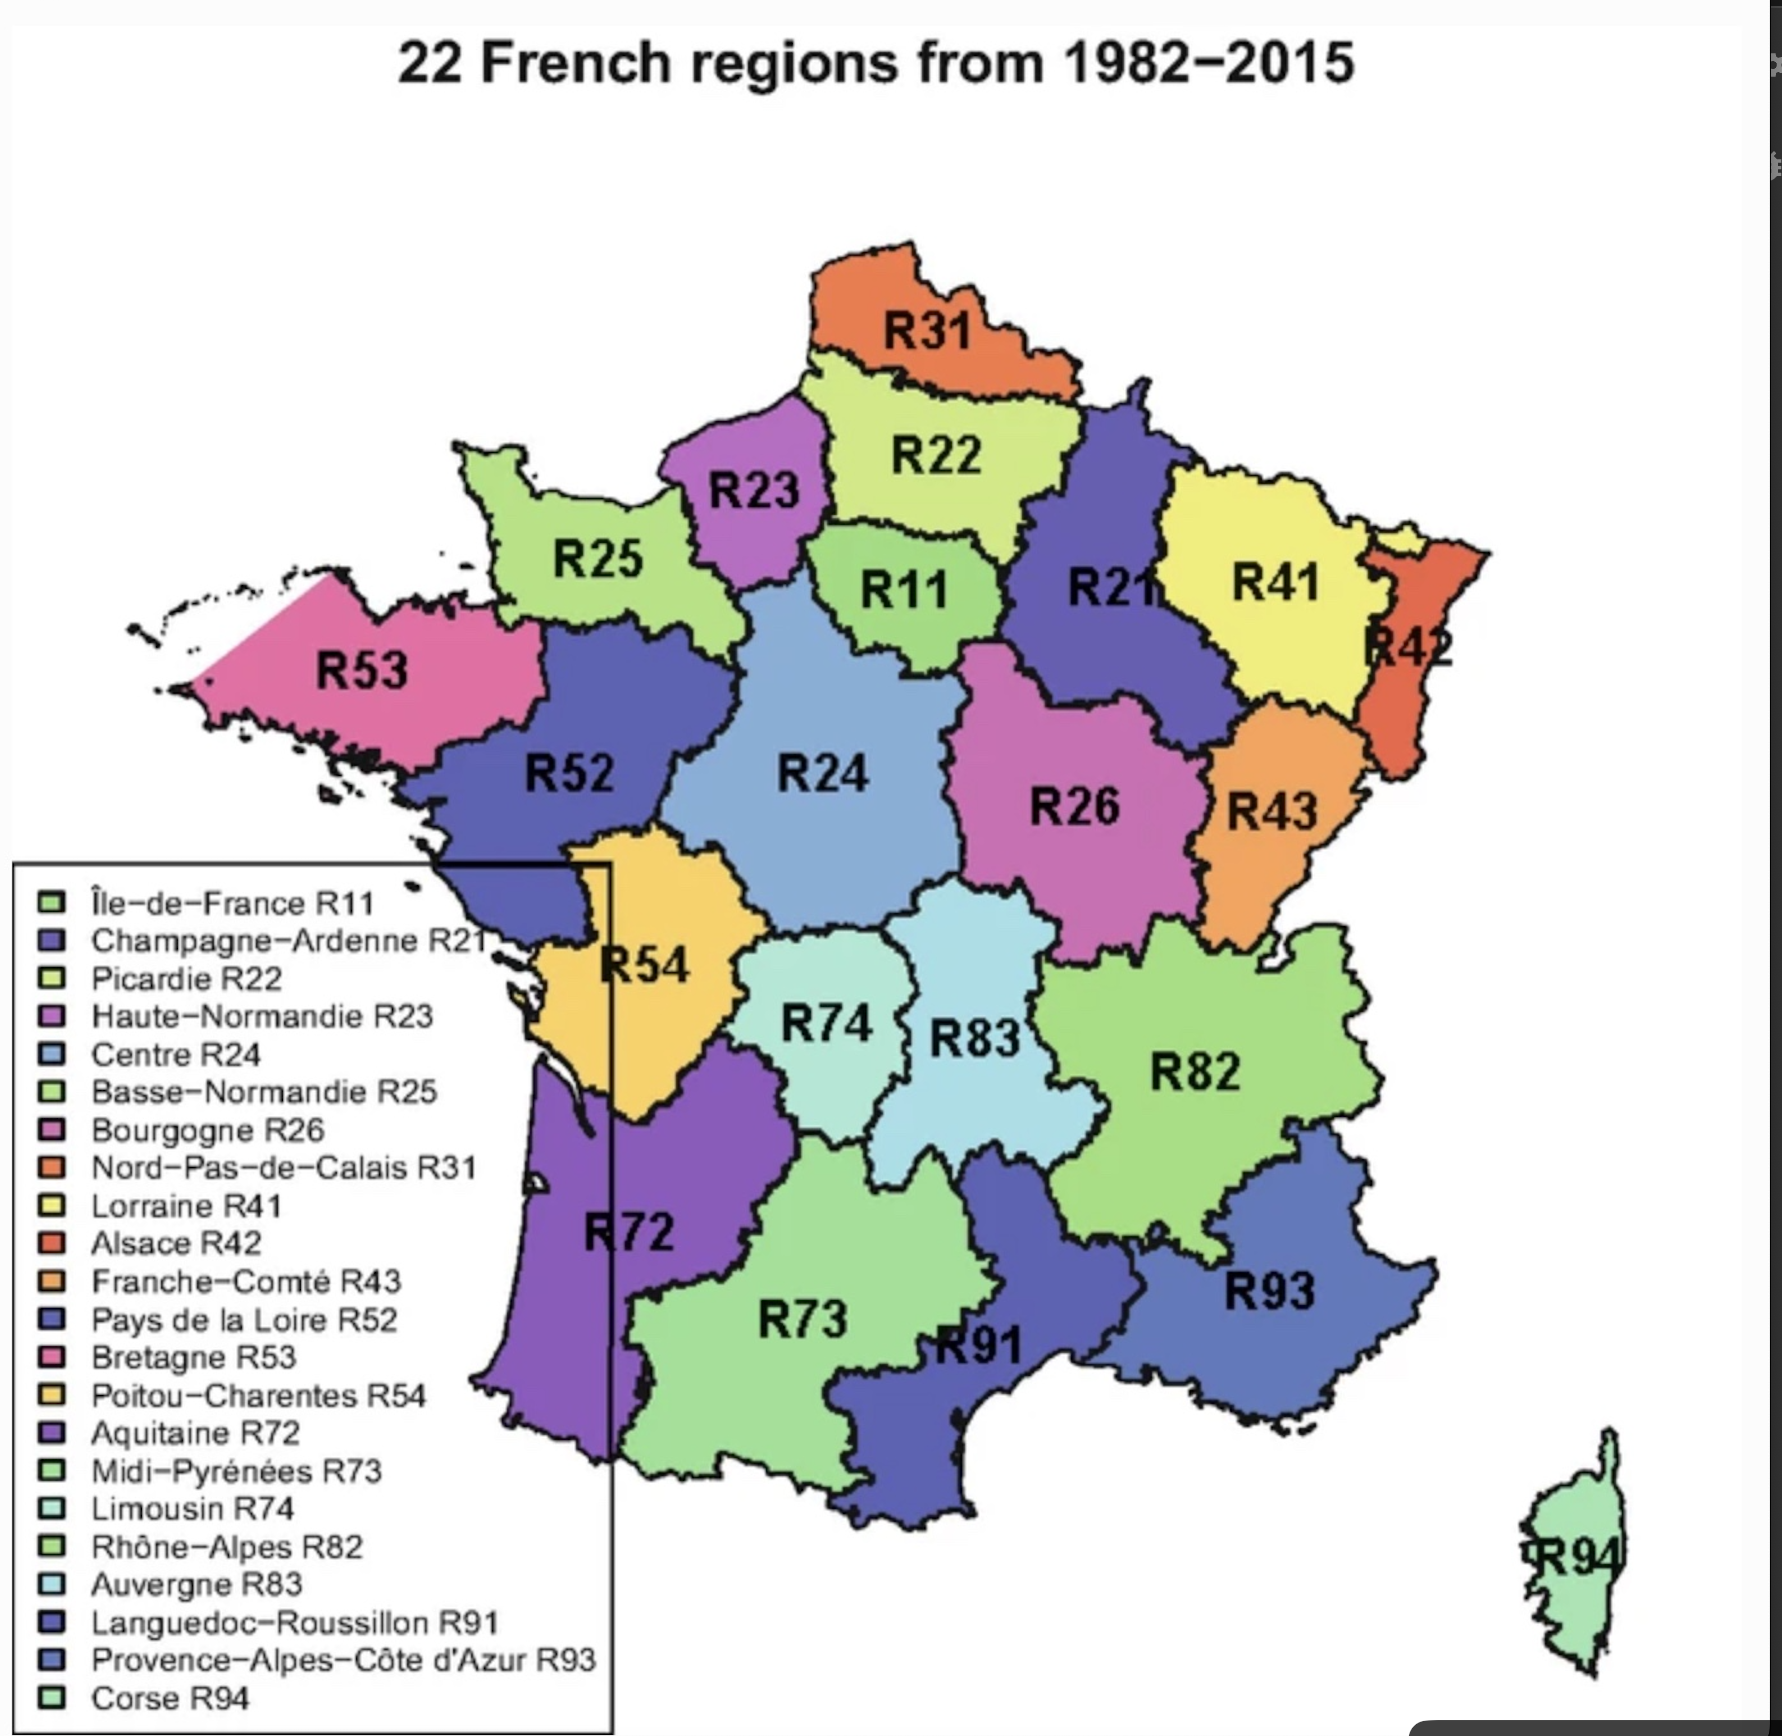

Region
'R24'    6183
'R82'    3956
'R93'    2722
'R11'    2372
'R53'    1779
'R52'    1482
'R72'     977
'R91'     916
'R31'     859
'R54'     759
'R41'     449
'R25'     427
'R73'     349
'R26'     325
'R22'     298
'R23'     209
'R74'     183
'R83'     133
'R94'     106
'R42'      83
'R21'      69
'R43'      36
Name: count, dtype: int64


In [34]:
from PIL import Image
from IPython.display import display
img = Image.open('regions.png')
display(img)
print(df_claim['Region'].value_counts())

In [35]:
grouped = df_claim.groupby('Region')['Target'].agg(['mean', 'std'])
print(grouped)

           mean       std
Region                   
'R11'  4157.959  8371.300
'R21'  2956.161  3886.273
'R22'  4311.382  9760.946
'R23'  4770.365  6757.489
'R24'  3566.280  8429.436
'R25'  3471.099  8045.004
'R26'  3954.388  7374.092
'R31'  4263.385  7864.345
'R41'  3842.251  9511.894
'R42'  3993.822  8280.902
'R43'  6961.839  9286.643
'R52'  3687.223  8345.949
'R53'  3512.013  7875.232
'R54'  3742.769  8006.840
'R72'  4757.867 10198.728
'R73'  3611.764  5637.108
'R74'  3361.474  6819.124
'R82'  4059.045  8517.479
'R83'  2864.671  3753.137
'R91'  5015.956  9989.924
'R93'  4706.015  9544.010
'R94'  4899.659  6038.914


### (42,43,41), (21,22,23,31), (74,73), 94 is Corsica... so an island... 

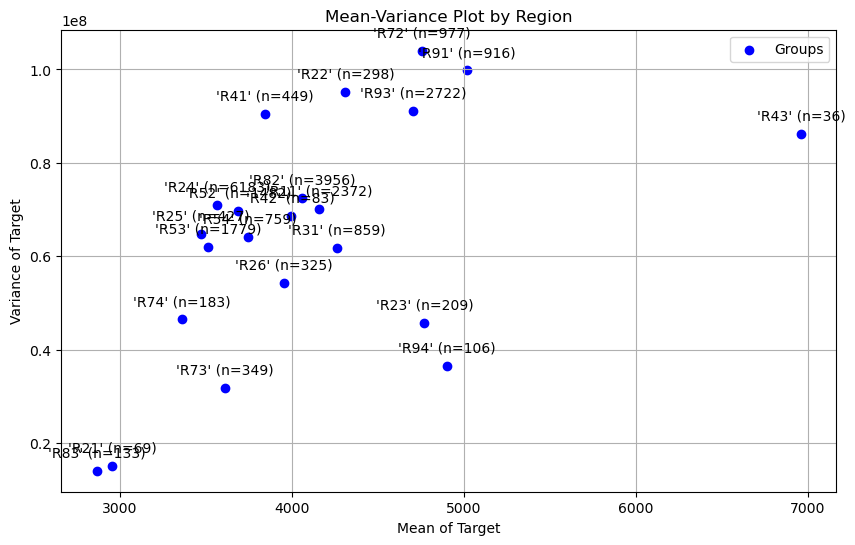

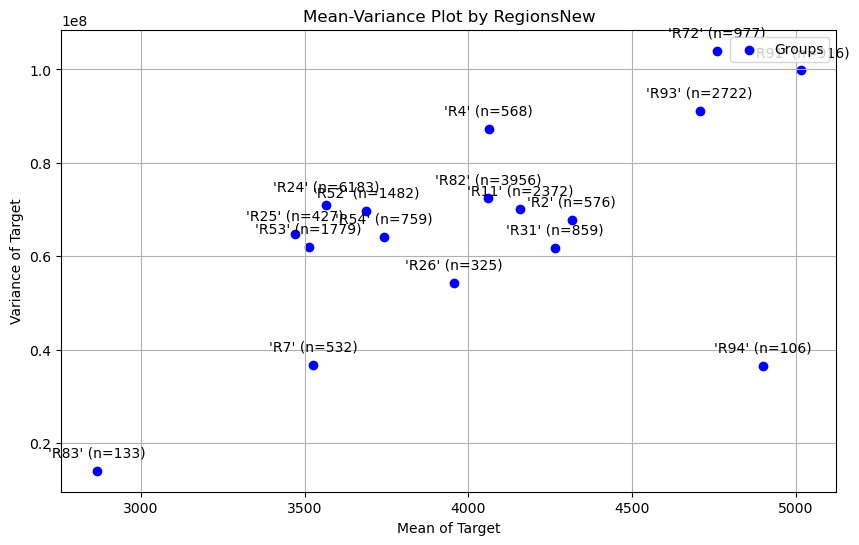

In [36]:
df_claim['RegionsNew'] = df_claim['Region'].copy()
condition = df_claim['RegionsNew'].isin(["'R42'", "'R43'", "'R41'"])
df_claim.loc[condition, 'RegionsNew'] = "'R4'"
condition = df_claim['RegionsNew'].isin(["'R73'", "'R74'"])
df_claim.loc[condition, 'RegionsNew'] = "'R7'"
condition = df_claim['RegionsNew'].isin(["'R21'", "'R22'", "'R23'"])
df_claim.loc[condition, 'RegionsNew'] = "'R2'"
plot_mean_var_plot_cat('Region', disable_occurance_label=False)
plot_mean_var_plot_cat('RegionsNew', disable_occurance_label=False)

### Last feature BonusMalus, but we keep everything as it is and just ceil it at 100.

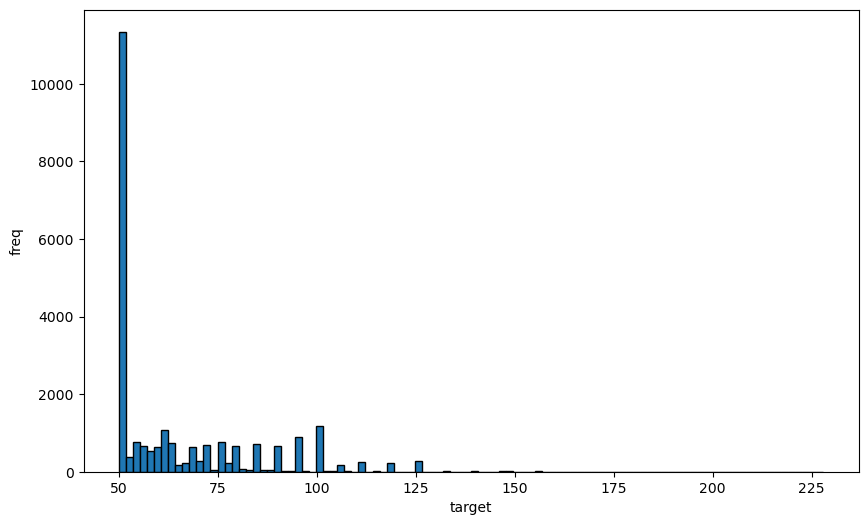

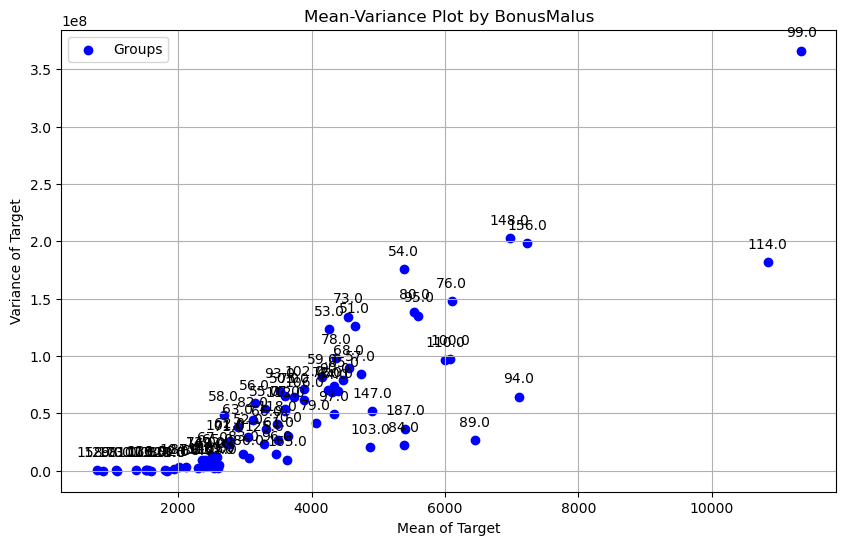

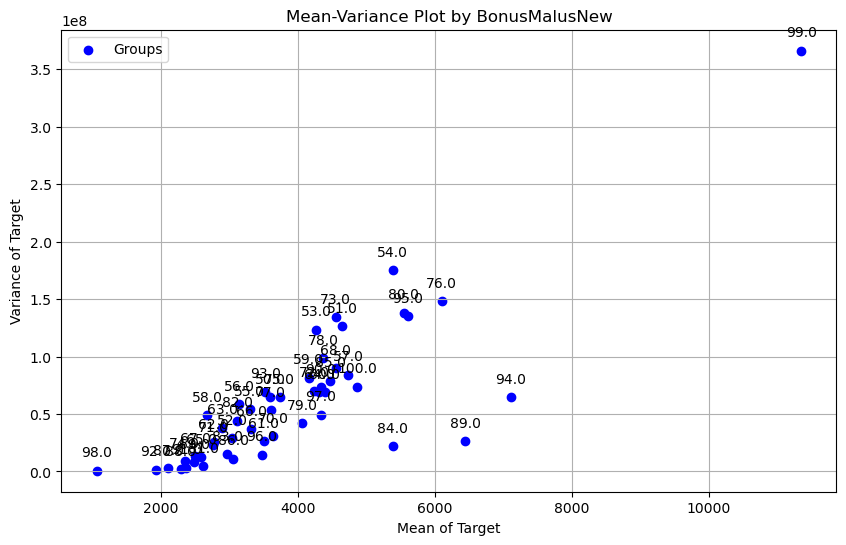

In [37]:
plot_metric_data('BonusMalus')
df_claim['BonusMalusNew'] = df_claim['BonusMalus'].copy()
df_claim.loc[df_claim['BonusMalus'] > 100, 'BonusMalusNew'] = 100
plot_mean_var_plot_cat('BonusMalus', disable_occurance_label=True)
plot_mean_var_plot_cat('BonusMalusNew', disable_occurance_label=True)


# Data preparation & Training

In [274]:
df_claim.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimAmount',
       'Target', 'Log_Target', 'LogDensity', 'DrivAgeClass', 'VehAgeClass',
       'VehPowerNew', 'RegionsNew', 'BonusMalusNew'],
      dtype='object')

In [39]:
df_use = df_claim.copy()
df_use.head()

df_use.drop(['ClaimAmount', 'IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Log_Target', 'Density', 'Region'], axis=1, inplace=True)
df_encoded = pd.get_dummies(df_use, columns=['Area', 'VehBrand', 'VehGas', 'RegionsNew', 'VehPowerNew', 'DrivAgeClass', 'VehAgeClass']).astype(float)


df_encoded['LogDensity'] = (df_encoded['LogDensity'] - df_encoded['LogDensity'].mean()) / df_encoded['LogDensity'].std()

df_encoded['BonusMalusNew'] = (df_encoded['BonusMalusNew'] - df_encoded['BonusMalusNew'].min()) / 50.0

In [43]:
### Here, I checked linear correlations among the features. Doesn't look too promising though...

In [41]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

X = df_encoded.drop('Target', axis=1)
y = np.log(df_encoded['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform it
y_train_unscaled = np.exp(np.array(y_train))
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)

# Transform the test data using the same scaler
y_test_unscaled = np.exp(np.array(y_test))
y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape(-1)

print(y_test_unscaled.shape)
print(y_test.shape)

(4935,)
(4935,)


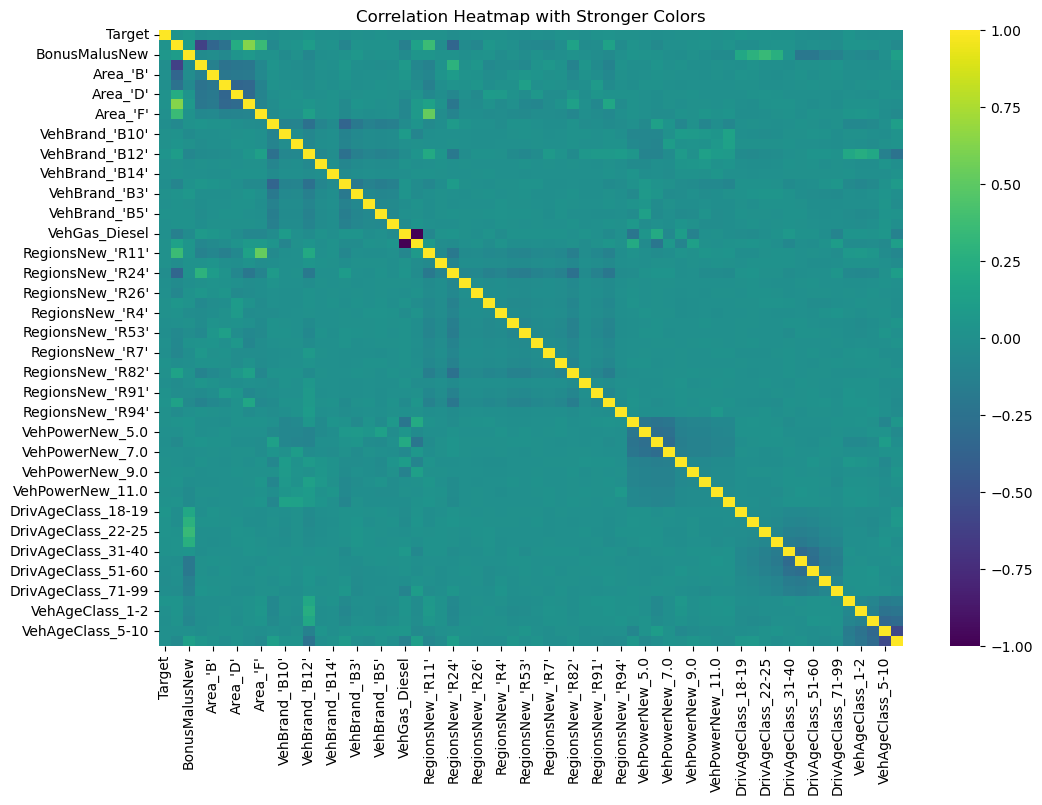

Columns with the highest correlation to 'Target':
BonusMalusNew        0.058
DrivAgeClass_18-19   0.039
VehAgeClass_0        0.036
VehBrand_'B12'       0.035
DrivAgeClass_22-25   0.030
RegionsNew_'R93'     0.029
RegionsNew_'R24'     0.029
DrivAgeClass_61-70   0.029
LogDensity           0.026
DrivAgeClass_20-21   0.025
Name: Target, dtype: float64


In [44]:
correlation_matrix = df_encoded.corr()
region_columns = [col for col in correlation_matrix.index if 'Region_' in col]
modified_corr_matrix = correlation_matrix.drop(index=region_columns)
plt.figure(figsize=(12, 8))
sb.heatmap(modified_corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Heatmap with Stronger Colors')
plt.show()
target_correlations = modified_corr_matrix['Target'].drop('Target').abs().sort_values(ascending=False)

print("Columns with the highest correlation to 'Target':")
print(target_correlations.head(10))


### Just a check what gamma function I will combine with gradient penalization later on... not so important

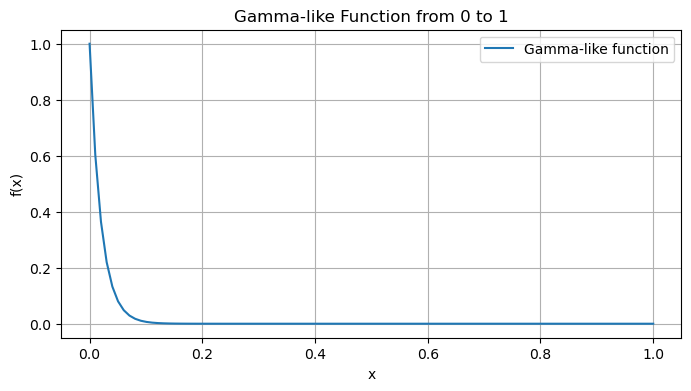

3.0295939175091164

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def gamma_function(x, alpha=50.0, beta=1.0):
    return np.exp(-alpha * np.power(x, beta))

x = np.linspace(0, 1, 100)

y = gamma_function(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, label="Gamma-like function")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gamma-like Function from 0 to 1')
plt.legend()
plt.grid(True)
plt.show()

gamma = lambda x : 4 * np.exp(-10 * np.power(x, 1))
gamma(0.027786577120423317)

### A Scaler where the critical part of the label value range, namely 0-25%, is spanned to 0-75% of the value range.

In [348]:
class CustomRangeScaler:
    def __init__(self):
        self.min_ = None
        self.max_ = None
        self.boundary_ = None

    def fit(self, data):
        self.min_ = np.min(data)
        self.max_ = np.max(data)
        self.boundary_ = self.min_ + 0.25 * (self.max_ - self.min_)

    def transform(self, data):
        # Scale the first part (min to boundary) to 0-0.75
        data_scaled_low = 0.75 * (data - self.min_) / (self.boundary_ - self.min_)

        # Scale the second part (boundary to max) to 0.75-1.0
        data_scaled_high = 0.75 + 0.25 * (data - self.boundary_) / (self.max_ - self.boundary_)

        data_scaled = np.where(data <= self.boundary_, data_scaled_low, data_scaled_high)
        return data_scaled

    def inverse_transform(self, scaled_data):
        # Inverse scaling for the first part
        data_original_low = (scaled_data / 0.75) * (self.boundary_ - self.min_) + self.min_

        # Inverse scaling for the second part
        data_original_high = ((scaled_data - 0.75) / 0.25) * (self.max_ - self.boundary_) + self.boundary_

        data_original = np.where(scaled_data <= 0.75, data_original_low, data_original_high)
        return data_original

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

### Next to RMSE, we are going to use an accuracy with tolerance for evaluation of our model. Furthermore,
### we will look at the target and prediction distributions

In [49]:
# Utils functions for nn
def acc_with_tolerance(preds, gt, tol=0.4):
    preds = preds.cpu().numpy() if torch.is_tensor(preds) else preds
    gt = gt.cpu().numpy() if torch.is_tensor(gt) else gt

    lower_bound = gt - gt * tol
    upper_bound = gt + gt * tol

    correct_preds = (lower_bound <= preds) & (preds <= upper_bound)
    return np.mean(correct_preds)

# network
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 200)  
        self.fc2 = nn.Linear(200, 100)               
        self.fc3 = nn.Linear(100, 50)                
        self.fc4 = nn.Linear(50, 1)                
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)                   
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

import torch.nn.functional as F

# weighted l1 loss
def weighted_l1_loss(inputs, targets, weights=None):
    loss = F.l1_loss(inputs, targets, reduction='none')
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def weighted_focal_l1_loss(inputs, targets, weights=None, activate='sigmoid', beta=.2, gamma=1):
    loss = F.l1_loss(inputs, targets, reduction='none')
    loss *= (torch.tanh(beta * torch.abs(inputs - targets))) ** gamma if activate == 'tanh' else \
        (2 * torch.sigmoid(beta * torch.abs(inputs - targets)) - 1) ** gamma
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

In [50]:
# lr parameter
lr=0.0001
epochs=250
batch_size=64
metric=acc_with_tolerance

#### So we are going to use a neural network for our predictions since it is able to learn complex distributions.
#### Notable candidates were GLMs and Gaussian Processes with a Gamma Likelihood (which I would have had to program myself). 
#### I had REAL trouble with the strange gamma distribution with its very long tail which lead to bad prediction distributions.
#### Due to the long tail, we have a data imbalance problem that I tried to tackle.
#### I read the paper https://arxiv.org/pdf/2102.09554.pdf published by Yang et al. 
#### There, they tried to solve the regression imbalance problem by applying a kernel onto the weights to "spread" the weights +
#### to boost gradients for underrepresented regions (technique is called Label Distribution Smoothing).
#### Below, you can see my implementation of LDS with some tweaks. 
#### To keep it short: It didn't do much, however, I only implemented one technique out of two. 
#### The second, Feature Distribution Smoothing, was not implemented (due to having invested already several hours to this challenge).
#### I had the problem, that through LDS, the tail gets more emphasis, but the "gamma-belly", meaning the data points with labels valued between 0-0.1 
#### (min-max-normalized), are lost, which lead to performance loss. 
#### So I added a sharp gamma function to the weights which skewed the target distribution again to the right and lead to a
#### slightly better performance than without weighting the loss. 


In [51]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from scipy.ndimage import convolve1d


class ImbalanceDataset(Dataset):
    def __init__(self, data_tensor, target_tensor, bins=100, reweight='none', \
                 lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        assert data_tensor.size(0) == target_tensor.size(0), \
            "Data and Targets must have the same number of samples"
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.min_val = target_tensor.min()
        self.max_val = target_tensor.max()
        self.bins = bins
        
        self.weights = self._prepare_weights(reweight, lds, lds_kernel, lds_ks, lds_sigma)

    def __len__(self):
        return self.data_tensor.size(0)

    def __getitem__(self, index):
        weight = np.asarray([self.weights[index]]).astype('float32') \
        if self.weights is not None else np.asarray([np.float32(1.)])
        return self.data_tensor[index], self.target_tensor[index], weight

    def _prepare_weights(self, reweight, lds=False, lds_kernel='gaussian', lds_ks=30, lds_sigma=10):
        assert reweight in {'none', 'inverse', 'sqrt_inv'}
        assert reweight != 'none' if lds else True, \
            "Set reweight to \'sqrt_inv\' (default) or \'inverse\' when using LDS"

        scaler = (self.max_val - self.min_val) / self.bins
        value_dict = {x: 0 for x in range(self.bins)}
        labels = self.target_tensor[:, -1].tolist()
        
        for label in labels:
            value_dict[min(self.bins - 1, int(label / scaler))] += 1
        if reweight == 'sqrt_inv':
            value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
        elif reweight == 'inverse':
            value_dict = {k: np.clip(v, 5, 1000) for k, v in value_dict.items()}  # clip weights for inverse re-weight
        num_per_label = [value_dict[min(self.bins - 1, int(label / scaler))] for label in labels]
        if not len(num_per_label) or reweight == 'none':
            return None

        if lds:
            lds_kernel_window = get_lds_kernel_window(lds_kernel, lds_ks, lds_sigma)
            print(f'Using LDS: [{lds_kernel.upper()}] ({lds_ks}/{lds_sigma})')
            smoothed_value = convolve1d(
                np.asarray([v for _, v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
            num_per_label = [smoothed_value[min(self.bins - 1, int(label / scaler))] for label in labels]

        #weights = [np.float32(1 / x) for x in num_per_label]
        weights = [np.float32(1 / x) for x in num_per_label]
        
        scaling = len(weights) / np.sum(weights)
        weights = [scaling * x for x in weights]
        weights = [np.clip(x,0.0001,100) for x in weights]
        # maybe better results with a gamma 
        gamma = lambda x : 10 * np.exp(-10 * np.power(x, 1))
        gamma_vals = [gamma(x) for x in labels]
        print(np.array(weights).shape, np.array(gamma_vals).shape)
        weights = np.array(weights) + np.array(gamma_vals) + np.array(labels)
        print(min(weights), max(weights))
        #weights = [scaling * x * x for x in weights]

        # here plot there weights and the labels
        
        return weights


19737


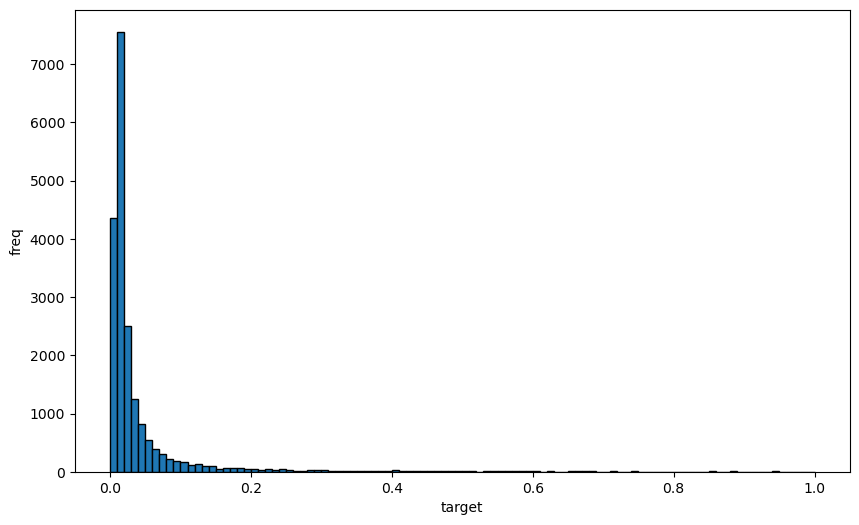

(4935,)
(4935,)
Using LDS: [GAUSSIAN] (5/2)
(19737,) (19737,)
5.195358574657478 27.176295397646534


In [52]:
X = df_encoded.drop('Target', axis=1)
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
#scaler = CustomRangeScaler()
scaler = MinMaxScaler()

# Fit on training data and transform it
y_train_unscaled = np.array(y_train)
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)


# Plotting the frequency of the unscaled and scaled data
#plot_metric_data_arr(y_train_unscaled)
plot_metric_data_arr(y_train)

# Transform the test data using the same scaler
y_test_unscaled = np.array(y_test)
y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape(-1)

print(y_test_unscaled.shape)
print(y_test.shape)


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_dataset = ImbalanceDataset(X_train_tensor, y_train_tensor, reweight='sqrt_inv', lds=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

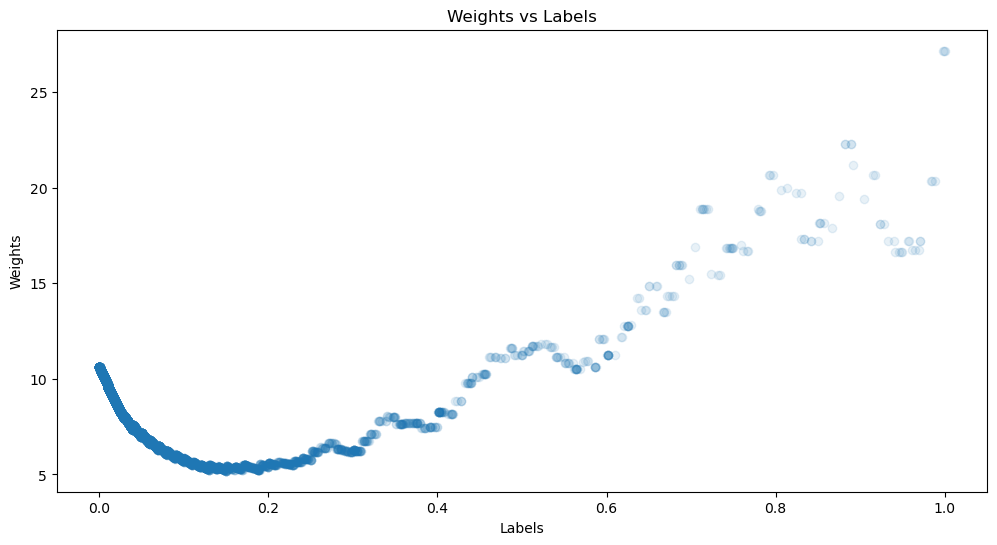

In [56]:
# Visualize weights
weights = []
labels = []
for _, label, weight in train_dataset:
    weights.append(weight[0])
    labels.append(label.item())  # Assuming label is a tensor

plt.figure(figsize=(12, 6))
plt.scatter(labels, weights, alpha=0.1)
plt.title('Weights vs Labels')
plt.xlabel('Labels')
plt.ylabel('Weights')
plt.show()


### NN Training

In [54]:
model = Net(X_train.shape[1])
#criterion = weighted_focal_l1_loss
criterion = weighted_l1_loss
#criterion = nn.L1Loss()
#criterion = L1Loss(penalty_weight=3, tol=100)
optimizer = optim.Adamax(model.parameters(), lr=lr)#, weight_decay=weight_decay)

for epoch in range(200):
    for batch in train_loader:
        X_batch, y_batch, weight = batch
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch, weight)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        # test set evaluation
        y_pred_test = model(X_test_tensor).numpy()
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).reshape(-1)
        
        accuracy_test = metric(y_pred_test, y_test_unscaled)

        # training set evaluation
        y_pred_train = model(X_train_tensor).numpy()
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        y_pred_train = scaler.inverse_transform(y_pred_train.reshape(-1, 1)).reshape(-1)
    
        accuracy_train = metric(y_pred_train, y_train_unscaled)

        print(f"Epoch {epoch+1}, Train RMSE: {rmse_train}, Train Accuracy: {accuracy_train}, Test RMSE: {rmse_test}, Test Accuracy: {accuracy_test}")

    model.train()


#run_neural_network(batch_size=64)

Epoch 1, Train RMSE: 0.08931350632257996, Train Accuracy: 0.36368242387394234, Test RMSE: 0.08868032922567187, Test Accuracy: 0.356838905775076
Epoch 2, Train RMSE: 0.08936203688036552, Train Accuracy: 0.39048487612099103, Test RMSE: 0.08872183911309311, Test Accuracy: 0.3817629179331307
Epoch 3, Train RMSE: 0.08952280786996393, Train Accuracy: 0.40229011501241324, Test RMSE: 0.08889603140454282, Test Accuracy: 0.39250253292806486
Epoch 4, Train RMSE: 0.08965490587378529, Train Accuracy: 0.4147540153012109, Test RMSE: 0.0890088594386645, Test Accuracy: 0.41134751773049644
Epoch 5, Train RMSE: 0.08986820752898, Train Accuracy: 0.4169326645386837, Test RMSE: 0.08923276327426967, Test Accuracy: 0.4121580547112462
Epoch 6, Train RMSE: 0.08953967130155059, Train Accuracy: 0.42331661346709226, Test RMSE: 0.08888171663625605, Test Accuracy: 0.41742654508611954
Epoch 7, Train RMSE: 0.08955039921485736, Train Accuracy: 0.42671125297664286, Test RMSE: 0.08887823049231407, Test Accuracy: 0.424518

KeyboardInterrupt: 

In [59]:
stop

NameError: name 'stop' is not defined

### Results with LDS + gamma weight

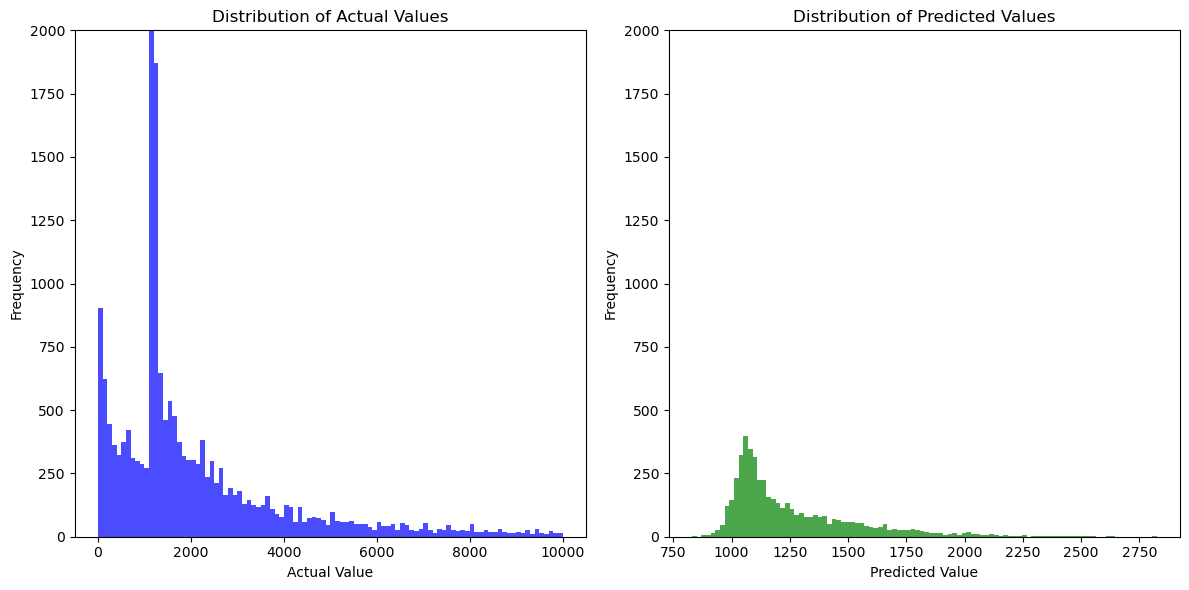

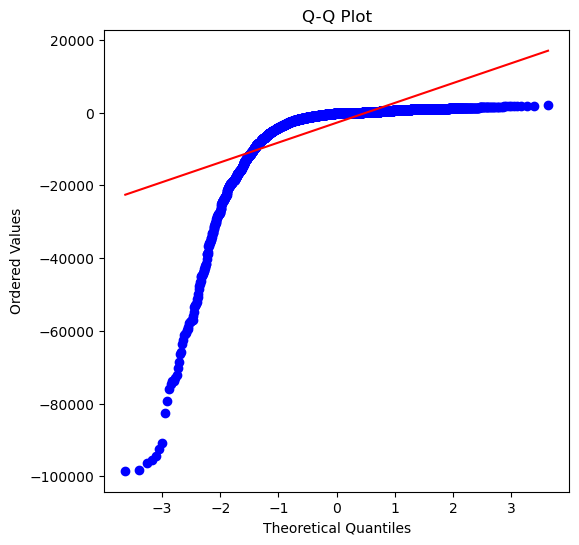

In [738]:
# Test: ca. 0.43, Train ca. 0.43
plot_gt_and_preds(y_train_unscaled, y_pred_test, limit=10000)
plot_qq(y_pred_test, y_test_unscaled)

### Results with LDS

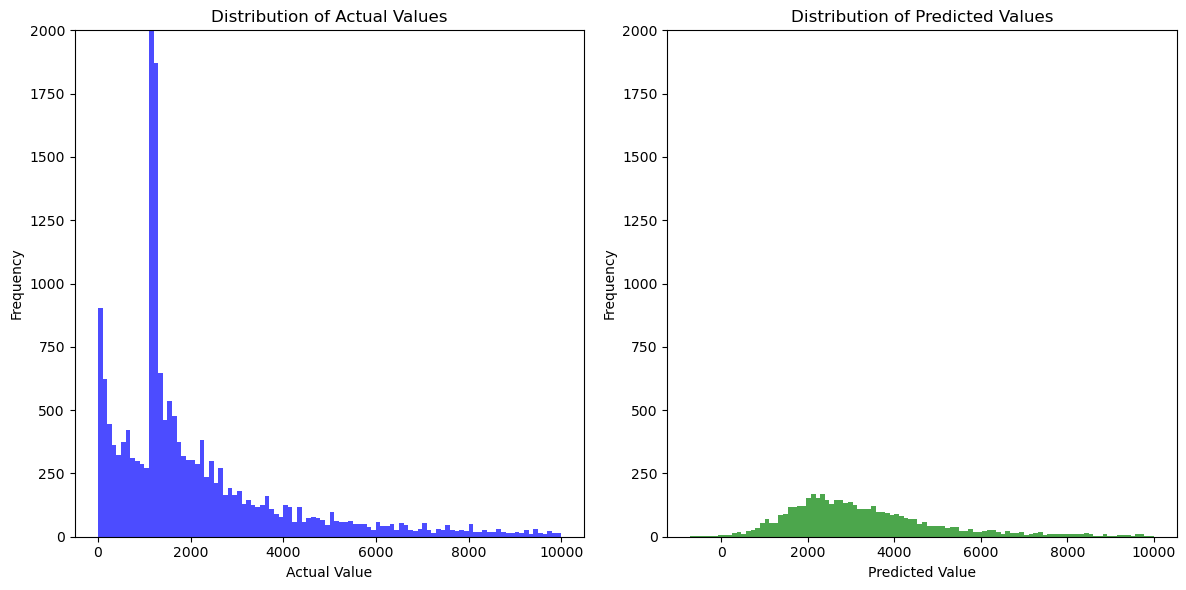

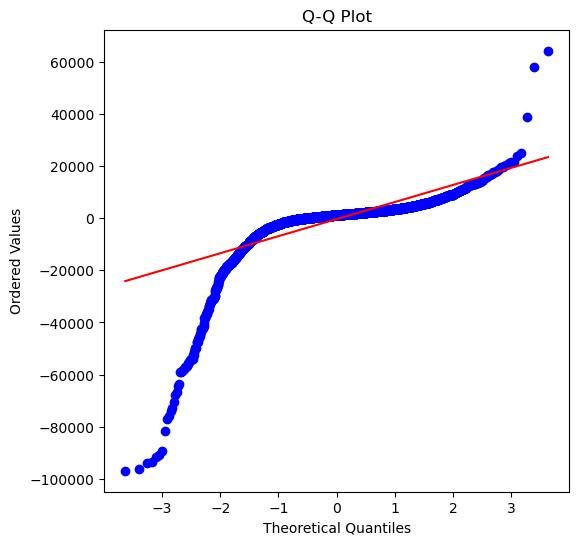

In [525]:
# with sqrt_inv and fairly small gaussian kernel parameters (5 kernel size, 2 sigma)
# Test Acc: ca. 21%, ca. Train Acc: 25%
plot_gt_and_preds(y_train_unscaled, y_pred_test, limit=10000)
plot_qq(y_pred_test, y_test_unscaled)

### Results without LDS

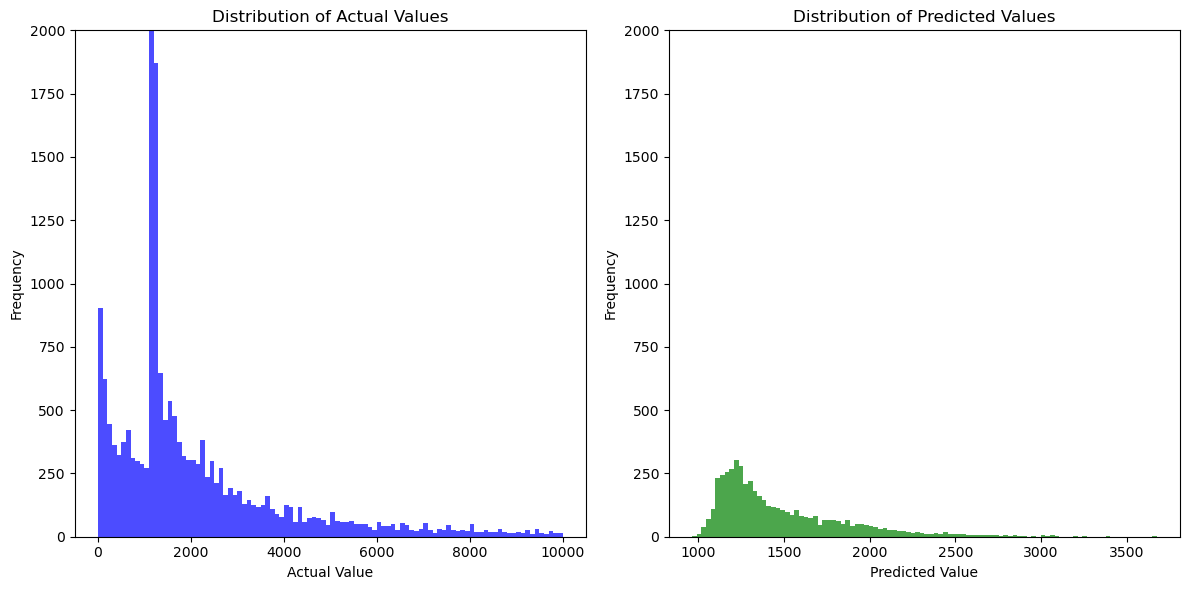

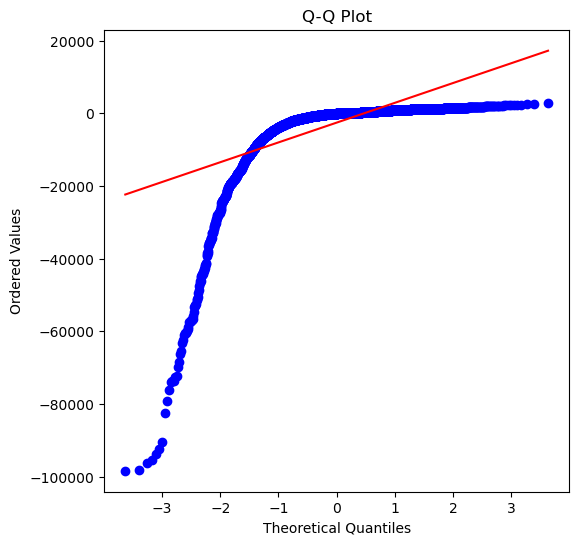

In [492]:
# without weighting: Test Acc: ca. 41% u. ca. 42% Training Acc.
plot_gt_and_preds(y_train_unscaled, y_pred_test, limit=10000)
plot_qq(y_pred_test, y_test_unscaled)

# Started on Gaussian Processes...

### But at this point, I had already invested too much time so I skipped a detailed evaluation 
### of this model. Nevertheless, even though using a Gaussian Likelihood, the target distribution 
### didn't look that bad. 

In [224]:
import torch
from torch.distributions import Gamma
import gpytorch

class GammaLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    def __init__(self):
        super().__init__()
        self.register_parameter(name="concentration", parameter=torch.nn.Parameter(torch.zeros(1)))
        self.register_parameter(name="rate", parameter=torch.nn.Parameter(torch.zeros(1)))

    def forward(self, function_samples):
        concentration = self.concentration.exp()
        rate = self.rate.exp()
        return Gamma(concentration, rate)

    def expected_log_prob(self, observation, function_dist):
        pass


In [740]:
import torch
import gpytorch
from matplotlib import pyplot as plt

X = df_encoded.drop('Target', axis=1)
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

y_train_unscaled = np.array(y_train)
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)

y_test_unscaled = np.array(y_test)
y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape(-1)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

epsilon = 1e-6

# Adjust the values
y_train = np.clip(y_train, epsilon, 1 - epsilon)
y_test = np.clip(y_test, epsilon, 1 - epsilon)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

num_inducing = 250  # This can be adjusted
training_iter = 250
inducing_points = X_train[:num_inducing]

class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(SparseGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood for sparse GP
model = SparseGPModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Train the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

for i in range(training_iter):
    optimizer.zero_grad()
    
    output = model(X_train)
    loss = -mll(output, y_train)
    
    loss.backward()
    optimizer.step()

    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        y_pred = likelihood(model(X_test)).mean
        y_pred_numpy = y_pred.detach().numpy()  # Detach from the graph and convert to numpy
        y_pred_rescaled = scaler.inverse_transform(y_pred_numpy.reshape(-1, 1)).reshape(-1)

    tolerance = 0.25  # 25%
    accurate_predictions = np.abs(y_pred_rescaled - y_test_unscaled) <= (tolerance * np.abs(y_test_unscaled))
    accuracy = np.mean(accurate_predictions)

    print(f"Iteration {i+1}: Custom accuracy (within 25% of actual value): {accuracy * 100:.2f}%")

    model.train()
    likelihood.train()

Iteration 1: Custom accuracy (within 25% of actual value): 0.10%
Iteration 2: Custom accuracy (within 25% of actual value): 0.18%
Iteration 3: Custom accuracy (within 25% of actual value): 0.32%
Iteration 4: Custom accuracy (within 25% of actual value): 0.51%
Iteration 5: Custom accuracy (within 25% of actual value): 1.03%
Iteration 6: Custom accuracy (within 25% of actual value): 2.33%
Iteration 7: Custom accuracy (within 25% of actual value): 2.76%
Iteration 8: Custom accuracy (within 25% of actual value): 2.65%
Iteration 9: Custom accuracy (within 25% of actual value): 2.35%
Iteration 10: Custom accuracy (within 25% of actual value): 1.95%
Iteration 11: Custom accuracy (within 25% of actual value): 2.03%
Iteration 12: Custom accuracy (within 25% of actual value): 2.11%
Iteration 13: Custom accuracy (within 25% of actual value): 2.43%
Iteration 14: Custom accuracy (within 25% of actual value): 2.63%
Iteration 15: Custom accuracy (within 25% of actual value): 2.70%
Iteration 16: Custo

KeyboardInterrupt: 

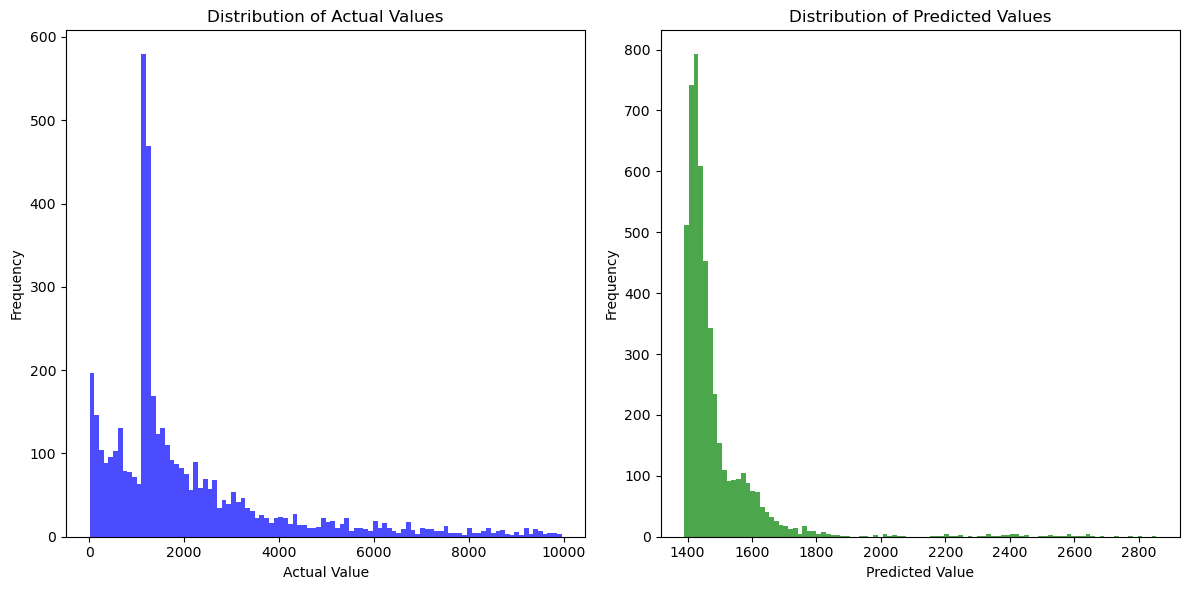

In [239]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting the distribution of actual values
plt.subplot(1, 2, 1)
plt.hist(y_test_unscaled[y_test_unscaled < 10000], bins=100, alpha=0.7, color='blue')
plt.title('Distribution of Actual Values')
plt.xlabel('Actual Value')
plt.ylabel('Frequency')


# Plotting the distribution of predicted values
plt.subplot(1, 2, 2)
plt.hist(y_pred_rescaled[y_pred_rescaled < 10000], bins=100, alpha=0.7, color='green')
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Thanks

### Thank you for this challenge. Even though I'm not very happy with 
### the results/performance of the model, it was real fun. 